# Import dataset

In [2]:
# Import library and model
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pandas import read_csv
from matplotlib import pyplot
from sklearn.metrics import mean_squared_error
from sklearn import metrics
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, GRU

In [3]:
# Import Dataset
 # EUR - VND
eur = pd.read_csv('EUR_VND.csv')
 # GBP - VND
gbp = pd.read_csv("GBP_VND.csv")
 # JPY - VND
jpy = pd.read_csv("JPY_VND.csv")
# Convert
eur = eur['Sale'].replace({',':''}, regex=True).astype(float)
gbp = gbp['Sale'].replace({',':''}, regex=True).astype(float)
jpy = jpy['Sale'].replace({',':''}, regex=True).astype(float)

In [4]:
# Split train, test
#### EUR - VND
  # case 1. 7:3
train_eur_1 = eur[:int(0.7*len(eur))]
test_eur_1 = eur[int(0.7*len(eur)):]
  # case 2. 8:2
train_eur_2 = eur[:int(0.8*len(eur))]
test_eur_2 = eur[int(0.8*len(eur)):]
  # case 3. 9:1
train_eur_3 = eur[:int(0.9*len(eur))]
test_eur_3 = eur[int(0.9*len(eur)):]
#### GBP - VND
  # case 1. 7:3
train_gbp_1 = gbp[:int(0.7*len(gbp))]
test_gbp_1 = gbp[int(0.7*len(gbp)):]
  # case 2. 8:2
train_gbp_2 = gbp[:int(0.8*len(gbp))]
test_gbp_2 = gbp[int(0.8*len(gbp)):]
  # case 3. 9:1
train_gbp_3 = gbp[:int(0.9*len(gbp))]
test_gbp_3 = gbp[int(0.9*len(gbp)):]
#### JPY - VND
  # case 1. 7:3
train_jpy_1 = jpy[:int(0.7*len(jpy))]
test_jpy_1 = jpy[int(0.7*len(jpy)):]
  # case 2. 8:2
train_jpy_2 = jpy[:int(0.8*len(jpy))]
test_jpy_2 = jpy[int(0.8*len(jpy)):]
  # case 3. 9:1
train_jpy_3 = jpy[:int(0.9*len(jpy))]
test_jpy_3 = jpy[int(0.9*len(jpy)):]

# Scale data

In [5]:
scaler=MinMaxScaler(feature_range=(0,1))

# Functions

In [6]:
def standardizate_data(train, test, pre_test, f30, f60, f90):
  train = np.reshape(train, (-1,1))
  train1 = scaler.inverse_transform(train)

  test = np.reshape(test, (-1,1))
  test1 = scaler.inverse_transform(test)

  pre_test = np.reshape(pre_test, (-1,1))
  pre_test1 = scaler.inverse_transform(pre_test)

  f30 = np.reshape(f30, (-1,1))
  f30_1 = scaler.inverse_transform(f30)
   
  f60 = np.reshape(f60, (-1,1))
  f60_1 = scaler.inverse_transform(f60)
  
  f90 = np.reshape(f90, (-1,1))
  f90_1 = scaler.inverse_transform(f90)
    
  return train1, test1, pre_test1, f30_1, f60_1, f90_1

In [7]:
# Model Accuracy Evaluation Function
def accuracy(forecast, actual):
    forecast = np.array(forecast)
    actual = np.array(actual)
    mape = np.mean(np.abs(forecast - actual)/np.abs(actual))*100  # MAPE
    mae = np.mean(np.abs(forecast - actual))    # MAE
    rmse = np.mean((forecast - actual)**2)**.5  # RMSE

    print('RMSE =',rmse)
    print('MAPE =',mape)
    print('MAE =',mae)

In [8]:
# Function to convert an array of values into a dataset matrix
def create_dataset(dataset, time_step=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-time_step-1):
		a = dataset[i:(i+time_step), 0]   ###i=0, X=0,1,2,3-----99   Y=100
		dataX.append(a)
		dataY.append(dataset[i + time_step, 0])
	return np.array(dataX), np.array(dataY)

# Function to convert data
def convert_data(train, test, time_step):
    # Reshape into X = t, t+1, t+2 ,..., t+99 and Y = t+100
    X_train, y_train = create_dataset(train, time_step)
    X_test, y_test = create_dataset(test, time_step)
    # Reshape input to be [samples, time steps, features] which is required for LSTM
    X_train =X_train.reshape(X_train.shape[0],X_train.shape[1] , 1)  # => 3D
    X_test = X_test.reshape(X_test.shape[0],X_test.shape[1] , 1)
    return X_train, y_train, X_test, y_test

# GRU (Gated Recurrent Units)


In [9]:
# Hàm dự báo 30 ngày tiếp theo
def forecast_days(model, test):
  x_input = test[len(test)-100:].reshape(1,-1)

  temp_input=list(x_input)
  temp_input=temp_input[0].tolist()

  f30=[]
  f60=[]
  f90=[]
  n_steps=100
  i=0
  while(i<=90):
      if(len(temp_input)>100):
          x_input=np.array(temp_input[1:])
          print("{} day input {}".format(i,x_input))
          x_input = x_input.reshape(1,-1)
          x_input = x_input.reshape((1, n_steps, 1)) #3D
          yhat = model.predict(x_input, verbose=0)
          print("{} day output {}".format(i,yhat))
          temp_input.extend(yhat[0].tolist())
          temp_input=temp_input[1:]
          if i <= 30:
            f30.extend(yhat.tolist())
          elif i <= 60:
            f60.extend(yhat.tolist())
          else:
            f90.extend(yhat.tolist())
          i=i+1
      else:
          x_input = x_input.reshape((1, n_steps, 1))
          yhat = model.predict(x_input, verbose=0)
          print(yhat[0])
          temp_input.extend(yhat[0].tolist())
          print(len(temp_input))
          f30.extend(yhat.tolist())
          i=i+1
  return f30, f60, f90

In [23]:
# Hàm trực quan hóa model
def visualize_GRU(model, train, test, pre_test, f30, f60, f90):
#     plt.figure(figsize=(12, 6))
    start_date = pd.to_datetime('3/1/2019')
    end_date = pd.to_datetime('3/1/2024')
    end_date_fc = pd.to_datetime('6/1/2024')

    index = pd.date_range(start=start_date, end=end_date_fc, freq='D')
    
    unique_years = index.year.unique()
    x_ticks = [pd.to_datetime(str(year)) for year in unique_years]
    
    plt.xticks(x_ticks, unique_years)    

    train_index = index[:len(train)]
    test_index = index[len(train): len(train) + len(test)]
    pre_test_index = index[len(train) + 101: len(train) + len(test)]

    f30_index = index[len(train) + len(test) - 1: len(train) + len(test) + 30]
    f60_index = index[len(train) + len(test) + 30: len(train) + len(test) + 60]
    f90_index = index[len(train) + len(test) + 60: len(train) + len(test) + 90]
    
    # Visualize
    plt.plot(train_index, scaler.inverse_transform(train))
    plt.plot(test_index, scaler.inverse_transform(test))
    plt.plot(pre_test_index,scaler.inverse_transform(pre_test))
    
    plt.plot(f30_index, scaler.inverse_transform(f30))
    plt.plot(f60_index, scaler.inverse_transform(f60))
    plt.plot(f90_index, scaler.inverse_transform(f90))
    
    plt.title('GRU Time Series Forecast')
    plt.xlabel('Date')
    plt.ylabel('Exchange Rate (VND)')
    plt.legend(['Train','Test','PredictedTest','ForecastNext30Days','ForecastNext60Days','ForecastNext90Days'])
    plt.show()

In [24]:
def implementGRU(train, test):
  time_step = 100
  X_train, y_train, X_test, y_test = convert_data(train, test, time_step)

  # Define GRU Model
  model = Sequential()
  model.add(GRU(64, input_shape=(time_step, 1)))
  model.add(Dense(1))
  model.compile(optimizer='adam', loss='mean_squared_error')

  # Fit model
  model.fit(X_train,y_train,validation_data=(X_test,y_test),epochs=100,batch_size=64,verbose=1)
  pre_test = model.predict(X_test)
  f30, f60, f90 = forecast_days(model, test)
  visualize_GRU(model, train, test, pre_test, f30, f60, f90)
  train, test, pre_test, f30, f60, f90 = standardizate_data(train, test, pre_test, f30, f60, f90)

  test1 = test[101:]
  print('- Model accuracy evaluation: ')
  accuracy(pre_test, test1)

**EUR_VND**

In [37]:
#### EUR - VND
eur_sc = scaler.fit_transform(np.array(eur).reshape(-1,1))
# case 1. 7:3
train_eur_1_sc = eur_sc[:int(0.7*len(eur))]
test_eur_1_sc = eur_sc[int(0.7*len(eur)):]
# case 2. 8:2
train_eur_2_sc = eur_sc[:int(0.8*len(eur))]
test_eur_2_sc = eur_sc[int(0.8*len(eur)):]
# case 3. 9:1
train_eur_3_sc = eur_sc[:int(0.9*len(eur))]
test_eur_3_sc = eur_sc[int(0.9*len(eur)):]

* Case 7:3

Epoch 1/100


C:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


19/19 ━━━━━━━━━━━━━━━━━━━━ 2s 57ms/step - loss: 0.1997 - val_loss: 0.0263
Epoch 2/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - loss: 0.0173 - val_loss: 0.0023
Epoch 3/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - loss: 0.0067 - val_loss: 0.0028
Epoch 4/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - loss: 0.0044 - val_loss: 0.0011
Epoch 5/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - loss: 0.0030 - val_loss: 9.4260e-04
Epoch 6/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - loss: 0.0023 - val_loss: 9.0884e-04
Epoch 7/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - loss: 0.0014 - val_loss: 5.2951e-04
Epoch 8/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - loss: 0.0011 - val_loss: 4.5823e-04
Epoch 9/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - loss: 7.4473e-04 - val_loss: 4.3800e-04
Epoch 10/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - loss: 5.8552e-04 - val_loss: 4.2215e-04
Epoch 11/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - loss: 5.4631e-04 - val_loss: 4.2181e-04
Epoch 12/100
19/19 ━━━━━

19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step - loss: 3.7171e-04 - val_loss: 3.1082e-04
Epoch 66/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step - loss: 3.3255e-04 - val_loss: 3.2003e-04
Epoch 67/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - loss: 3.3930e-04 - val_loss: 3.3546e-04
Epoch 68/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - loss: 3.9067e-04 - val_loss: 3.0825e-04
Epoch 69/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - loss: 3.5981e-04 - val_loss: 3.2068e-04
Epoch 70/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - loss: 3.8237e-04 - val_loss: 3.3355e-04
Epoch 71/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 43ms/step - loss: 3.8908e-04 - val_loss: 3.0725e-04
Epoch 72/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 57ms/step - loss: 3.6529e-04 - val_loss: 3.0875e-04
Epoch 73/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step - loss: 3.6410e-04 - val_loss: 3.0729e-04
Epoch 74/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 52ms/step - loss: 3.6036e-04 - val_loss: 3.0512e-04
Epoch 75/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step - loss: 3.

4 day output [[0.6976589]]
5 day input [0.68284045 0.70161148 0.68142376 0.66920489 0.66920489 0.66920489
 0.65078803 0.64087126 0.62156897 0.61607933 0.60651673 0.60651673
 0.60651673 0.60208961 0.61572516 0.61962104 0.66495484 0.69045511
 0.69045511 0.69045511 0.69328847 0.70391358 0.70462192 0.69612183
 0.70586152 0.70586152 0.70586152 0.7156012  0.72321587 0.74340358
 0.75934124 0.72534089 0.72534089 0.72534089 0.72675757 0.73649726
 0.70426775 0.7108199  0.69488224 0.69488224 0.69488224 0.69116345
 0.70019479 0.71471578 0.7311847  0.74057021 0.74057021 0.74057021
 0.72604923 0.71383035 0.7012573  0.70798654 0.7072782  0.7072782
 0.7072782  0.71737206 0.71648663 0.72073667 0.72976802 0.70391358
 0.70391358 0.70391358 0.68691341 0.65344431 0.66477776 0.64582964
 0.67115282 0.67115282 0.67115282 0.62652736 0.61590225 0.63591287
 0.6415796  0.63998583 0.63998583 0.63998583 0.64140251 0.6367983
 0.60917301 0.62705862 0.66265274 0.66265274 0.66265274 0.66584027
 0.6607048  0.66973614 0.

12 day output [[0.68811446]]
13 day input [0.62156897 0.61607933 0.60651673 0.60651673 0.60651673 0.60208961
 0.61572516 0.61962104 0.66495484 0.69045511 0.69045511 0.69045511
 0.69328847 0.70391358 0.70462192 0.69612183 0.70586152 0.70586152
 0.70586152 0.7156012  0.72321587 0.74340358 0.75934124 0.72534089
 0.72534089 0.72534089 0.72675757 0.73649726 0.70426775 0.7108199
 0.69488224 0.69488224 0.69488224 0.69116345 0.70019479 0.71471578
 0.7311847  0.74057021 0.74057021 0.74057021 0.72604923 0.71383035
 0.7012573  0.70798654 0.7072782  0.7072782  0.7072782  0.71737206
 0.71648663 0.72073667 0.72976802 0.70391358 0.70391358 0.70391358
 0.68691341 0.65344431 0.66477776 0.64582964 0.67115282 0.67115282
 0.67115282 0.62652736 0.61590225 0.63591287 0.6415796  0.63998583
 0.63998583 0.63998583 0.64140251 0.6367983  0.60917301 0.62705862
 0.66265274 0.66265274 0.66265274 0.66584027 0.6607048  0.66973614
 0.71524703 0.70940322 0.70940322 0.70940322 0.71985125 0.7168408
 0.69559058 0.71489286

22 day output [[0.67531073]]
23 day input [0.69045511 0.69045511 0.69328847 0.70391358 0.70462192 0.69612183
 0.70586152 0.70586152 0.70586152 0.7156012  0.72321587 0.74340358
 0.75934124 0.72534089 0.72534089 0.72534089 0.72675757 0.73649726
 0.70426775 0.7108199  0.69488224 0.69488224 0.69488224 0.69116345
 0.70019479 0.71471578 0.7311847  0.74057021 0.74057021 0.74057021
 0.72604923 0.71383035 0.7012573  0.70798654 0.7072782  0.7072782
 0.7072782  0.71737206 0.71648663 0.72073667 0.72976802 0.70391358
 0.70391358 0.70391358 0.68691341 0.65344431 0.66477776 0.64582964
 0.67115282 0.67115282 0.67115282 0.62652736 0.61590225 0.63591287
 0.6415796  0.63998583 0.63998583 0.63998583 0.64140251 0.6367983
 0.60917301 0.62705862 0.66265274 0.66265274 0.66265274 0.66584027
 0.6607048  0.66973614 0.71524703 0.70940322 0.70940322 0.70940322
 0.71985125 0.7168408  0.69559058 0.71489286 0.69966354 0.70204401
 0.7007997  0.69979101 0.69874185 0.6976589  0.69654459 0.69540167
 0.69423348 0.69304287

30 day output [[0.6651511]]
31 day input [0.70586152 0.7156012  0.72321587 0.74340358 0.75934124 0.72534089
 0.72534089 0.72534089 0.72675757 0.73649726 0.70426775 0.7108199
 0.69488224 0.69488224 0.69488224 0.69116345 0.70019479 0.71471578
 0.7311847  0.74057021 0.74057021 0.74057021 0.72604923 0.71383035
 0.7012573  0.70798654 0.7072782  0.7072782  0.7072782  0.71737206
 0.71648663 0.72073667 0.72976802 0.70391358 0.70391358 0.70391358
 0.68691341 0.65344431 0.66477776 0.64582964 0.67115282 0.67115282
 0.67115282 0.62652736 0.61590225 0.63591287 0.6415796  0.63998583
 0.63998583 0.63998583 0.64140251 0.6367983  0.60917301 0.62705862
 0.66265274 0.66265274 0.66265274 0.66584027 0.6607048  0.66973614
 0.71524703 0.70940322 0.70940322 0.70940322 0.71985125 0.7168408
 0.69559058 0.71489286 0.69966354 0.70204401 0.7007997  0.69979101
 0.69874185 0.6976589  0.69654459 0.69540167 0.69423348 0.69304287
 0.69183326 0.69060689 0.68936664 0.68811446 0.68685263 0.68558317
 0.68430728 0.68302679 

39 day output [[0.6541099]]
40 day input [0.73649726 0.70426775 0.7108199  0.69488224 0.69488224 0.69488224
 0.69116345 0.70019479 0.71471578 0.7311847  0.74057021 0.74057021
 0.74057021 0.72604923 0.71383035 0.7012573  0.70798654 0.7072782
 0.7072782  0.7072782  0.71737206 0.71648663 0.72073667 0.72976802
 0.70391358 0.70391358 0.70391358 0.68691341 0.65344431 0.66477776
 0.64582964 0.67115282 0.67115282 0.67115282 0.62652736 0.61590225
 0.63591287 0.6415796  0.63998583 0.63998583 0.63998583 0.64140251
 0.6367983  0.60917301 0.62705862 0.66265274 0.66265274 0.66265274
 0.66584027 0.6607048  0.66973614 0.71524703 0.70940322 0.70940322
 0.70940322 0.71985125 0.7168408  0.69559058 0.71489286 0.69966354
 0.70204401 0.7007997  0.69979101 0.69874185 0.6976589  0.69654459
 0.69540167 0.69423348 0.69304287 0.69183326 0.69060689 0.68936664
 0.68811446 0.68685263 0.68558317 0.68430728 0.68302679 0.68174291
 0.68045682 0.67916954 0.67788213 0.67659563 0.67531073 0.67402768
 0.67274773 0.67147082

47 day output [[0.6446807]]
48 day input [0.71471578 0.7311847  0.74057021 0.74057021 0.74057021 0.72604923
 0.71383035 0.7012573  0.70798654 0.7072782  0.7072782  0.7072782
 0.71737206 0.71648663 0.72073667 0.72976802 0.70391358 0.70391358
 0.70391358 0.68691341 0.65344431 0.66477776 0.64582964 0.67115282
 0.67115282 0.67115282 0.62652736 0.61590225 0.63591287 0.6415796
 0.63998583 0.63998583 0.63998583 0.64140251 0.6367983  0.60917301
 0.62705862 0.66265274 0.66265274 0.66265274 0.66584027 0.6607048
 0.66973614 0.71524703 0.70940322 0.70940322 0.70940322 0.71985125
 0.7168408  0.69559058 0.71489286 0.69966354 0.70204401 0.7007997
 0.69979101 0.69874185 0.6976589  0.69654459 0.69540167 0.69423348
 0.69304287 0.69183326 0.69060689 0.68936664 0.68811446 0.68685263
 0.68558317 0.68430728 0.68302679 0.68174291 0.68045682 0.67916954
 0.67788213 0.67659563 0.67531073 0.67402768 0.67274773 0.67147082
 0.6701979  0.66892916 0.66766495 0.66640556 0.66515112 0.66390187
 0.6626581  0.66141981 0.

55 day output [[0.6355787]]
56 day input [0.70798654 0.7072782  0.7072782  0.7072782  0.71737206 0.71648663
 0.72073667 0.72976802 0.70391358 0.70391358 0.70391358 0.68691341
 0.65344431 0.66477776 0.64582964 0.67115282 0.67115282 0.67115282
 0.62652736 0.61590225 0.63591287 0.6415796  0.63998583 0.63998583
 0.63998583 0.64140251 0.6367983  0.60917301 0.62705862 0.66265274
 0.66265274 0.66265274 0.66584027 0.6607048  0.66973614 0.71524703
 0.70940322 0.70940322 0.70940322 0.71985125 0.7168408  0.69559058
 0.71489286 0.69966354 0.70204401 0.7007997  0.69979101 0.69874185
 0.6976589  0.69654459 0.69540167 0.69423348 0.69304287 0.69183326
 0.69060689 0.68936664 0.68811446 0.68685263 0.68558317 0.68430728
 0.68302679 0.68174291 0.68045682 0.67916954 0.67788213 0.67659563
 0.67531073 0.67402768 0.67274773 0.67147082 0.6701979  0.66892916
 0.66766495 0.66640556 0.66515112 0.66390187 0.6626581  0.66141981
 0.66018683 0.65896004 0.65773863 0.65652329 0.65531367 0.6541099
 0.65291208 0.65171981

64 day output [[0.6256676]]
65 day input [0.70391358 0.70391358 0.68691341 0.65344431 0.66477776 0.64582964
 0.67115282 0.67115282 0.67115282 0.62652736 0.61590225 0.63591287
 0.6415796  0.63998583 0.63998583 0.63998583 0.64140251 0.6367983
 0.60917301 0.62705862 0.66265274 0.66265274 0.66265274 0.66584027
 0.6607048  0.66973614 0.71524703 0.70940322 0.70940322 0.70940322
 0.71985125 0.7168408  0.69559058 0.71489286 0.69966354 0.70204401
 0.7007997  0.69979101 0.69874185 0.6976589  0.69654459 0.69540167
 0.69423348 0.69304287 0.69183326 0.69060689 0.68936664 0.68811446
 0.68685263 0.68558317 0.68430728 0.68302679 0.68174291 0.68045682
 0.67916954 0.67788213 0.67659563 0.67531073 0.67402768 0.67274773
 0.67147082 0.6701979  0.66892916 0.66766495 0.66640556 0.66515112
 0.66390187 0.6626581  0.66141981 0.66018683 0.65896004 0.65773863
 0.65652329 0.65531367 0.6541099  0.65291208 0.65171981 0.65053302
 0.64935178 0.64817601 0.64700574 0.64584059 0.64468068 0.6435259
 0.64237624 0.64123166 

72 day output [[0.61709726]]
73 day input [0.67115282 0.62652736 0.61590225 0.63591287 0.6415796  0.63998583
 0.63998583 0.63998583 0.64140251 0.6367983  0.60917301 0.62705862
 0.66265274 0.66265274 0.66265274 0.66584027 0.6607048  0.66973614
 0.71524703 0.70940322 0.70940322 0.70940322 0.71985125 0.7168408
 0.69559058 0.71489286 0.69966354 0.70204401 0.7007997  0.69979101
 0.69874185 0.6976589  0.69654459 0.69540167 0.69423348 0.69304287
 0.69183326 0.69060689 0.68936664 0.68811446 0.68685263 0.68558317
 0.68430728 0.68302679 0.68174291 0.68045682 0.67916954 0.67788213
 0.67659563 0.67531073 0.67402768 0.67274773 0.67147082 0.6701979
 0.66892916 0.66766495 0.66640556 0.66515112 0.66390187 0.6626581
 0.66141981 0.66018683 0.65896004 0.65773863 0.65652329 0.65531367
 0.6541099  0.65291208 0.65171981 0.65053302 0.64935178 0.64817601
 0.64700574 0.64584059 0.64468068 0.6435259  0.64237624 0.64123166
 0.6400916  0.63895655 0.63782609 0.63670015 0.63557869 0.6344617
 0.63334846 0.6322397  0

82 day output [[0.60663563]]
83 day input [0.60917301 0.62705862 0.66265274 0.66265274 0.66265274 0.66584027
 0.6607048  0.66973614 0.71524703 0.70940322 0.70940322 0.70940322
 0.71985125 0.7168408  0.69559058 0.71489286 0.69966354 0.70204401
 0.7007997  0.69979101 0.69874185 0.6976589  0.69654459 0.69540167
 0.69423348 0.69304287 0.69183326 0.69060689 0.68936664 0.68811446
 0.68685263 0.68558317 0.68430728 0.68302679 0.68174291 0.68045682
 0.67916954 0.67788213 0.67659563 0.67531073 0.67402768 0.67274773
 0.67147082 0.6701979  0.66892916 0.66766495 0.66640556 0.66515112
 0.66390187 0.6626581  0.66141981 0.66018683 0.65896004 0.65773863
 0.65652329 0.65531367 0.6541099  0.65291208 0.65171981 0.65053302
 0.64935178 0.64817601 0.64700574 0.64584059 0.64468068 0.6435259
 0.64237624 0.64123166 0.6400916  0.63895655 0.63782609 0.63670015
 0.63557869 0.6344617  0.63334846 0.6322397  0.63113475 0.63003373
 0.62893653 0.6278432  0.62675357 0.62566757 0.62458479 0.62350571
 0.62242991 0.6213573

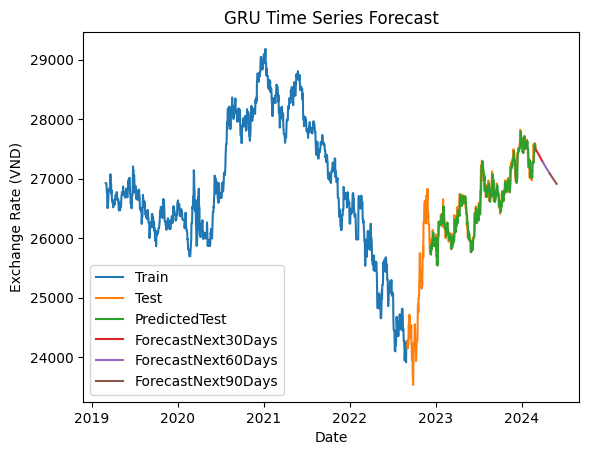

- Model accuracy evaluation: 
RMSE = 131.14957866867712
MAPE = 0.36963458471966654
MAE = 98.49106456236039


In [38]:
implementGRU(train_eur_1_sc, test_eur_1_sc)

* Case 8:2

Epoch 1/100


C:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


22/22 ━━━━━━━━━━━━━━━━━━━━ 2s 53ms/step - loss: 0.2800 - val_loss: 0.0193
Epoch 2/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 43ms/step - loss: 0.0200 - val_loss: 0.0038
Epoch 3/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 43ms/step - loss: 0.0077 - val_loss: 9.3472e-04
Epoch 4/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 42ms/step - loss: 0.0049 - val_loss: 7.2741e-04
Epoch 5/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step - loss: 0.0029 - val_loss: 6.3126e-04
Epoch 6/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step - loss: 0.0019 - val_loss: 5.7880e-04
Epoch 7/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - loss: 0.0012 - val_loss: 6.4773e-04
Epoch 8/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step - loss: 8.4170e-04 - val_loss: 6.1226e-04
Epoch 9/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step - loss: 8.0076e-04 - val_loss: 5.7138e-04
Epoch 10/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 43ms/step - loss: 8.4773e-04 - val_loss: 5.8407e-04
Epoch 11/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step - loss: 8.4244e-04 - val_loss: 5.5842e-04
Epoch 12/100

Epoch 65/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - loss: 4.7112e-04 - val_loss: 3.3858e-04
Epoch 66/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 53ms/step - loss: 4.9691e-04 - val_loss: 3.5830e-04
Epoch 67/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 54ms/step - loss: 4.5395e-04 - val_loss: 3.7064e-04
Epoch 68/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 53ms/step - loss: 5.0397e-04 - val_loss: 3.4032e-04
Epoch 69/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 52ms/step - loss: 4.7152e-04 - val_loss: 3.2959e-04
Epoch 70/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 43ms/step - loss: 4.7898e-04 - val_loss: 3.2852e-04
Epoch 71/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step - loss: 4.6817e-04 - val_loss: 3.2998e-04
Epoch 72/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step - loss: 5.0218e-04 - val_loss: 3.2449e-04
Epoch 73/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - loss: 4.7511e-04 - val_loss: 3.2445e-04
Epoch 74/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - loss: 4.7875e-04 - val_loss: 3.3494e-04
Epoch 75/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 48ms/st

4 day output [[0.7232193]]
5 day input [0.68284045 0.70161148 0.68142376 0.66920489 0.66920489 0.66920489
 0.65078803 0.64087126 0.62156897 0.61607933 0.60651673 0.60651673
 0.60651673 0.60208961 0.61572516 0.61962104 0.66495484 0.69045511
 0.69045511 0.69045511 0.69328847 0.70391358 0.70462192 0.69612183
 0.70586152 0.70586152 0.70586152 0.7156012  0.72321587 0.74340358
 0.75934124 0.72534089 0.72534089 0.72534089 0.72675757 0.73649726
 0.70426775 0.7108199  0.69488224 0.69488224 0.69488224 0.69116345
 0.70019479 0.71471578 0.7311847  0.74057021 0.74057021 0.74057021
 0.72604923 0.71383035 0.7012573  0.70798654 0.7072782  0.7072782
 0.7072782  0.71737206 0.71648663 0.72073667 0.72976802 0.70391358
 0.70391358 0.70391358 0.68691341 0.65344431 0.66477776 0.64582964
 0.67115282 0.67115282 0.67115282 0.62652736 0.61590225 0.63591287
 0.6415796  0.63998583 0.63998583 0.63998583 0.64140251 0.6367983
 0.60917301 0.62705862 0.66265274 0.66265274 0.66265274 0.66584027
 0.6607048  0.66973614 0.

12 day output [[0.7562438]]
13 day input [0.62156897 0.61607933 0.60651673 0.60651673 0.60651673 0.60208961
 0.61572516 0.61962104 0.66495484 0.69045511 0.69045511 0.69045511
 0.69328847 0.70391358 0.70462192 0.69612183 0.70586152 0.70586152
 0.70586152 0.7156012  0.72321587 0.74340358 0.75934124 0.72534089
 0.72534089 0.72534089 0.72675757 0.73649726 0.70426775 0.7108199
 0.69488224 0.69488224 0.69488224 0.69116345 0.70019479 0.71471578
 0.7311847  0.74057021 0.74057021 0.74057021 0.72604923 0.71383035
 0.7012573  0.70798654 0.7072782  0.7072782  0.7072782  0.71737206
 0.71648663 0.72073667 0.72976802 0.70391358 0.70391358 0.70391358
 0.68691341 0.65344431 0.66477776 0.64582964 0.67115282 0.67115282
 0.67115282 0.62652736 0.61590225 0.63591287 0.6415796  0.63998583
 0.63998583 0.63998583 0.64140251 0.6367983  0.60917301 0.62705862
 0.66265274 0.66265274 0.66265274 0.66584027 0.6607048  0.66973614
 0.71524703 0.70940322 0.70940322 0.70940322 0.71985125 0.7168408
 0.69559058 0.71489286 

20 day output [[0.79096884]]
21 day input [0.66495484 0.69045511 0.69045511 0.69045511 0.69328847 0.70391358
 0.70462192 0.69612183 0.70586152 0.70586152 0.70586152 0.7156012
 0.72321587 0.74340358 0.75934124 0.72534089 0.72534089 0.72534089
 0.72675757 0.73649726 0.70426775 0.7108199  0.69488224 0.69488224
 0.69488224 0.69116345 0.70019479 0.71471578 0.7311847  0.74057021
 0.74057021 0.74057021 0.72604923 0.71383035 0.7012573  0.70798654
 0.7072782  0.7072782  0.7072782  0.71737206 0.71648663 0.72073667
 0.72976802 0.70391358 0.70391358 0.70391358 0.68691341 0.65344431
 0.66477776 0.64582964 0.67115282 0.67115282 0.67115282 0.62652736
 0.61590225 0.63591287 0.6415796  0.63998583 0.63998583 0.63998583
 0.64140251 0.6367983  0.60917301 0.62705862 0.66265274 0.66265274
 0.66265274 0.66584027 0.6607048  0.66973614 0.71524703 0.70940322
 0.70940322 0.70940322 0.71985125 0.7168408  0.69559058 0.71489286
 0.69966354 0.70929098 0.71142799 0.71530533 0.71924305 0.72321928
 0.72723794 0.7312921

28 day output [[0.8270789]]
29 day input [0.70586152 0.70586152 0.70586152 0.7156012  0.72321587 0.74340358
 0.75934124 0.72534089 0.72534089 0.72534089 0.72675757 0.73649726
 0.70426775 0.7108199  0.69488224 0.69488224 0.69488224 0.69116345
 0.70019479 0.71471578 0.7311847  0.74057021 0.74057021 0.74057021
 0.72604923 0.71383035 0.7012573  0.70798654 0.7072782  0.7072782
 0.7072782  0.71737206 0.71648663 0.72073667 0.72976802 0.70391358
 0.70391358 0.70391358 0.68691341 0.65344431 0.66477776 0.64582964
 0.67115282 0.67115282 0.67115282 0.62652736 0.61590225 0.63591287
 0.6415796  0.63998583 0.63998583 0.63998583 0.64140251 0.6367983
 0.60917301 0.62705862 0.66265274 0.66265274 0.66265274 0.66584027
 0.6607048  0.66973614 0.71524703 0.70940322 0.70940322 0.70940322
 0.71985125 0.7168408  0.69559058 0.71489286 0.69966354 0.70929098
 0.71142799 0.71530533 0.71924305 0.72321928 0.72723794 0.73129213
 0.73538011 0.73949713 0.74364197 0.74781471 0.75201577 0.75624382
 0.760499   0.76477975 

37 day output [[0.869134]]
38 day input [0.72534089 0.72675757 0.73649726 0.70426775 0.7108199  0.69488224
 0.69488224 0.69488224 0.69116345 0.70019479 0.71471578 0.7311847
 0.74057021 0.74057021 0.74057021 0.72604923 0.71383035 0.7012573
 0.70798654 0.7072782  0.7072782  0.7072782  0.71737206 0.71648663
 0.72073667 0.72976802 0.70391358 0.70391358 0.70391358 0.68691341
 0.65344431 0.66477776 0.64582964 0.67115282 0.67115282 0.67115282
 0.62652736 0.61590225 0.63591287 0.6415796  0.63998583 0.63998583
 0.63998583 0.64140251 0.6367983  0.60917301 0.62705862 0.66265274
 0.66265274 0.66265274 0.66584027 0.6607048  0.66973614 0.71524703
 0.70940322 0.70940322 0.70940322 0.71985125 0.7168408  0.69559058
 0.71489286 0.69966354 0.70929098 0.71142799 0.71530533 0.71924305
 0.72321928 0.72723794 0.73129213 0.73538011 0.73949713 0.74364197
 0.74781471 0.75201577 0.75624382 0.760499   0.76477975 0.76908582
 0.77341646 0.77777106 0.78214896 0.78654844 0.79096884 0.79540771
 0.79986852 0.80435181 0

48 day output [[0.92203015]]
49 day input [0.7311847  0.74057021 0.74057021 0.74057021 0.72604923 0.71383035
 0.7012573  0.70798654 0.7072782  0.7072782  0.7072782  0.71737206
 0.71648663 0.72073667 0.72976802 0.70391358 0.70391358 0.70391358
 0.68691341 0.65344431 0.66477776 0.64582964 0.67115282 0.67115282
 0.67115282 0.62652736 0.61590225 0.63591287 0.6415796  0.63998583
 0.63998583 0.63998583 0.64140251 0.6367983  0.60917301 0.62705862
 0.66265274 0.66265274 0.66265274 0.66584027 0.6607048  0.66973614
 0.71524703 0.70940322 0.70940322 0.70940322 0.71985125 0.7168408
 0.69559058 0.71489286 0.69966354 0.70929098 0.71142799 0.71530533
 0.71924305 0.72321928 0.72723794 0.73129213 0.73538011 0.73949713
 0.74364197 0.74781471 0.75201577 0.75624382 0.760499   0.76477975
 0.76908582 0.77341646 0.77777106 0.78214896 0.78654844 0.79096884
 0.79540771 0.79986852 0.80435181 0.80885619 0.81338137 0.81792659
 0.82249284 0.82707888 0.83168328 0.83630693 0.8409481  0.84560579
 0.85027927 0.8549674

56 day output [[0.9609419]]
57 day input [0.7072782  0.7072782  0.7072782  0.71737206 0.71648663 0.72073667
 0.72976802 0.70391358 0.70391358 0.70391358 0.68691341 0.65344431
 0.66477776 0.64582964 0.67115282 0.67115282 0.67115282 0.62652736
 0.61590225 0.63591287 0.6415796  0.63998583 0.63998583 0.63998583
 0.64140251 0.6367983  0.60917301 0.62705862 0.66265274 0.66265274
 0.66265274 0.66584027 0.6607048  0.66973614 0.71524703 0.70940322
 0.70940322 0.70940322 0.71985125 0.7168408  0.69559058 0.71489286
 0.69966354 0.70929098 0.71142799 0.71530533 0.71924305 0.72321928
 0.72723794 0.73129213 0.73538011 0.73949713 0.74364197 0.74781471
 0.75201577 0.75624382 0.760499   0.76477975 0.76908582 0.77341646
 0.77777106 0.78214896 0.78654844 0.79096884 0.79540771 0.79986852
 0.80435181 0.80885619 0.81338137 0.81792659 0.82249284 0.82707888
 0.83168328 0.83630693 0.8409481  0.84560579 0.85027927 0.85496747
 0.85967278 0.86439657 0.86913401 0.87388563 0.87865061 0.88342863
 0.88822174 0.8930246

64 day output [[0.9997142]]
65 day input [0.70391358 0.70391358 0.68691341 0.65344431 0.66477776 0.64582964
 0.67115282 0.67115282 0.67115282 0.62652736 0.61590225 0.63591287
 0.6415796  0.63998583 0.63998583 0.63998583 0.64140251 0.6367983
 0.60917301 0.62705862 0.66265274 0.66265274 0.66265274 0.66584027
 0.6607048  0.66973614 0.71524703 0.70940322 0.70940322 0.70940322
 0.71985125 0.7168408  0.69559058 0.71489286 0.69966354 0.70929098
 0.71142799 0.71530533 0.71924305 0.72321928 0.72723794 0.73129213
 0.73538011 0.73949713 0.74364197 0.74781471 0.75201577 0.75624382
 0.760499   0.76477975 0.76908582 0.77341646 0.77777106 0.78214896
 0.78654844 0.79096884 0.79540771 0.79986852 0.80435181 0.80885619
 0.81338137 0.81792659 0.82249284 0.82707888 0.83168328 0.83630693
 0.8409481  0.84560579 0.85027927 0.85496747 0.85967278 0.86439657
 0.86913401 0.87388563 0.87865061 0.88342863 0.88822174 0.89302468
 0.89783984 0.90266383 0.90749663 0.91233665 0.91718131 0.92203015
 0.92688257 0.93173891

72 day output [[1.0378453]]
73 day input [0.67115282 0.62652736 0.61590225 0.63591287 0.6415796  0.63998583
 0.63998583 0.63998583 0.64140251 0.6367983  0.60917301 0.62705862
 0.66265274 0.66265274 0.66265274 0.66584027 0.6607048  0.66973614
 0.71524703 0.70940322 0.70940322 0.70940322 0.71985125 0.7168408
 0.69559058 0.71489286 0.69966354 0.70929098 0.71142799 0.71530533
 0.71924305 0.72321928 0.72723794 0.73129213 0.73538011 0.73949713
 0.74364197 0.74781471 0.75201577 0.75624382 0.760499   0.76477975
 0.76908582 0.77341646 0.77777106 0.78214896 0.78654844 0.79096884
 0.79540771 0.79986852 0.80435181 0.80885619 0.81338137 0.81792659
 0.82249284 0.82707888 0.83168328 0.83630693 0.8409481  0.84560579
 0.85027927 0.85496747 0.85967278 0.86439657 0.86913401 0.87388563
 0.87865061 0.88342863 0.88822174 0.89302468 0.89783984 0.90266383
 0.90749663 0.91233665 0.91718131 0.92203015 0.92688257 0.93173891
 0.93659949 0.94146371 0.94633204 0.95120263 0.95607346 0.96094191
 0.96580851 0.97067147

80 day output [[1.0747024]]
81 day input [0.64140251 0.6367983  0.60917301 0.62705862 0.66265274 0.66265274
 0.66265274 0.66584027 0.6607048  0.66973614 0.71524703 0.70940322
 0.70940322 0.70940322 0.71985125 0.7168408  0.69559058 0.71489286
 0.69966354 0.70929098 0.71142799 0.71530533 0.71924305 0.72321928
 0.72723794 0.73129213 0.73538011 0.73949713 0.74364197 0.74781471
 0.75201577 0.75624382 0.760499   0.76477975 0.76908582 0.77341646
 0.77777106 0.78214896 0.78654844 0.79096884 0.79540771 0.79986852
 0.80435181 0.80885619 0.81338137 0.81792659 0.82249284 0.82707888
 0.83168328 0.83630693 0.8409481  0.84560579 0.85027927 0.85496747
 0.85967278 0.86439657 0.86913401 0.87388563 0.87865061 0.88342863
 0.88822174 0.89302468 0.89783984 0.90266383 0.90749663 0.91233665
 0.91718131 0.92203015 0.92688257 0.93173891 0.93659949 0.94146371
 0.94633204 0.95120263 0.95607346 0.96094191 0.96580851 0.97067147
 0.97552931 0.98038059 0.98522538 0.990062   0.99489105 0.9997142
 1.00452495 1.00932634

88 day output [[1.1095679]]
89 day input [0.6607048  0.66973614 0.71524703 0.70940322 0.70940322 0.70940322
 0.71985125 0.7168408  0.69559058 0.71489286 0.69966354 0.70929098
 0.71142799 0.71530533 0.71924305 0.72321928 0.72723794 0.73129213
 0.73538011 0.73949713 0.74364197 0.74781471 0.75201577 0.75624382
 0.760499   0.76477975 0.76908582 0.77341646 0.77777106 0.78214896
 0.78654844 0.79096884 0.79540771 0.79986852 0.80435181 0.80885619
 0.81338137 0.81792659 0.82249284 0.82707888 0.83168328 0.83630693
 0.8409481  0.84560579 0.85027927 0.85496747 0.85967278 0.86439657
 0.86913401 0.87388563 0.87865061 0.88342863 0.88822174 0.89302468
 0.89783984 0.90266383 0.90749663 0.91233665 0.91718131 0.92203015
 0.92688257 0.93173891 0.93659949 0.94146371 0.94633204 0.95120263
 0.95607346 0.96094191 0.96580851 0.97067147 0.97552931 0.98038059
 0.98522538 0.990062   0.99489105 0.9997142  1.00452495 1.00932634
 1.01411939 1.01890123 1.02366459 1.02841282 1.03313708 1.03784525
 1.0425365  1.0472135

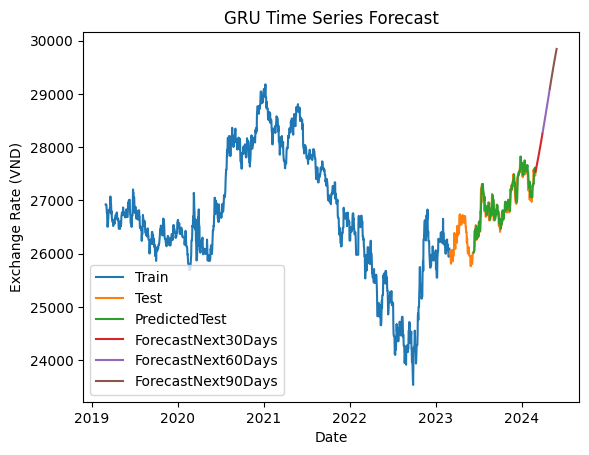

- Model accuracy evaluation: 
RMSE = 135.70615645615192
MAPE = 0.3888653430751822
MAE = 104.83986594460242


In [39]:
implementGRU(train_eur_2_sc, test_eur_2_sc)

* Case 9:1

Epoch 1/100


C:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


25/25 ━━━━━━━━━━━━━━━━━━━━ 3s 58ms/step - loss: 0.2183 - val_loss: 0.0035
Epoch 2/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 48ms/step - loss: 0.0097 - val_loss: 0.0013
Epoch 3/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - loss: 0.0055 - val_loss: 0.0019
Epoch 4/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 48ms/step - loss: 0.0032 - val_loss: 0.0010
Epoch 5/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 48ms/step - loss: 0.0018 - val_loss: 6.3972e-04
Epoch 6/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 48ms/step - loss: 0.0010 - val_loss: 5.4780e-04
Epoch 7/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - loss: 7.9745e-04 - val_loss: 5.4298e-04
Epoch 8/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 48ms/step - loss: 7.3141e-04 - val_loss: 6.0895e-04
Epoch 9/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step - loss: 7.6481e-04 - val_loss: 4.5646e-04
Epoch 10/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - loss: 6.8449e-04 - val_loss: 4.4495e-04
Epoch 11/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 42ms/step - loss: 6.7429e-04 - val_loss: 4.5106e-04
Epoch 12/100
25/

Epoch 65/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step - loss: 4.9633e-04 - val_loss: 2.7693e-04
Epoch 66/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - loss: 4.1598e-04 - val_loss: 3.1526e-04
Epoch 67/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step - loss: 4.3228e-04 - val_loss: 4.8016e-04
Epoch 68/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step - loss: 4.5316e-04 - val_loss: 3.0912e-04
Epoch 69/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - loss: 5.1439e-04 - val_loss: 2.7362e-04
Epoch 70/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - loss: 4.1437e-04 - val_loss: 2.8553e-04
Epoch 71/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 42ms/step - loss: 3.9094e-04 - val_loss: 2.7247e-04
Epoch 72/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step - loss: 3.9910e-04 - val_loss: 2.8152e-04
Epoch 73/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - loss: 4.0638e-04 - val_loss: 2.8665e-04
Epoch 74/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step - loss: 4.5138e-04 - val_loss: 2.9127e-04
Epoch 75/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 42ms/st

5 day output [[0.66800934]]
6 day input [0.70161148 0.68142376 0.66920489 0.66920489 0.66920489 0.65078803
 0.64087126 0.62156897 0.61607933 0.60651673 0.60651673 0.60651673
 0.60208961 0.61572516 0.61962104 0.66495484 0.69045511 0.69045511
 0.69045511 0.69328847 0.70391358 0.70462192 0.69612183 0.70586152
 0.70586152 0.70586152 0.7156012  0.72321587 0.74340358 0.75934124
 0.72534089 0.72534089 0.72534089 0.72675757 0.73649726 0.70426775
 0.7108199  0.69488224 0.69488224 0.69488224 0.69116345 0.70019479
 0.71471578 0.7311847  0.74057021 0.74057021 0.74057021 0.72604923
 0.71383035 0.7012573  0.70798654 0.7072782  0.7072782  0.7072782
 0.71737206 0.71648663 0.72073667 0.72976802 0.70391358 0.70391358
 0.70391358 0.68691341 0.65344431 0.66477776 0.64582964 0.67115282
 0.67115282 0.67115282 0.62652736 0.61590225 0.63591287 0.6415796
 0.63998583 0.63998583 0.63998583 0.64140251 0.6367983  0.60917301
 0.62705862 0.66265274 0.66265274 0.66265274 0.66584027 0.6607048
 0.66973614 0.71524703 0.

15 day output [[0.6096325]]
16 day input [0.60651673 0.60651673 0.60208961 0.61572516 0.61962104 0.66495484
 0.69045511 0.69045511 0.69045511 0.69328847 0.70391358 0.70462192
 0.69612183 0.70586152 0.70586152 0.70586152 0.7156012  0.72321587
 0.74340358 0.75934124 0.72534089 0.72534089 0.72534089 0.72675757
 0.73649726 0.70426775 0.7108199  0.69488224 0.69488224 0.69488224
 0.69116345 0.70019479 0.71471578 0.7311847  0.74057021 0.74057021
 0.74057021 0.72604923 0.71383035 0.7012573  0.70798654 0.7072782
 0.7072782  0.7072782  0.71737206 0.71648663 0.72073667 0.72976802
 0.70391358 0.70391358 0.70391358 0.68691341 0.65344431 0.66477776
 0.64582964 0.67115282 0.67115282 0.67115282 0.62652736 0.61590225
 0.63591287 0.6415796  0.63998583 0.63998583 0.63998583 0.64140251
 0.6367983  0.60917301 0.62705862 0.66265274 0.66265274 0.66265274
 0.66584027 0.6607048  0.66973614 0.71524703 0.70940322 0.70940322
 0.70940322 0.71985125 0.7168408  0.69559058 0.71489286 0.69966354
 0.69634473 0.69073731

23 day output [[0.56495446]]
24 day input [0.69045511 0.69328847 0.70391358 0.70462192 0.69612183 0.70586152
 0.70586152 0.70586152 0.7156012  0.72321587 0.74340358 0.75934124
 0.72534089 0.72534089 0.72534089 0.72675757 0.73649726 0.70426775
 0.7108199  0.69488224 0.69488224 0.69488224 0.69116345 0.70019479
 0.71471578 0.7311847  0.74057021 0.74057021 0.74057021 0.72604923
 0.71383035 0.7012573  0.70798654 0.7072782  0.7072782  0.7072782
 0.71737206 0.71648663 0.72073667 0.72976802 0.70391358 0.70391358
 0.70391358 0.68691341 0.65344431 0.66477776 0.64582964 0.67115282
 0.67115282 0.67115282 0.62652736 0.61590225 0.63591287 0.6415796
 0.63998583 0.63998583 0.63998583 0.64140251 0.6367983  0.60917301
 0.62705862 0.66265274 0.66265274 0.66265274 0.66584027 0.6607048
 0.66973614 0.71524703 0.70940322 0.70940322 0.70940322 0.71985125
 0.7168408  0.69559058 0.71489286 0.69966354 0.69634473 0.69073731
 0.68515462 0.67949569 0.67377794 0.66800934 0.66220111 0.65636373
 0.65050691 0.64463949 

31 day output [[0.52389294]]
32 day input [0.7156012  0.72321587 0.74340358 0.75934124 0.72534089 0.72534089
 0.72534089 0.72675757 0.73649726 0.70426775 0.7108199  0.69488224
 0.69488224 0.69488224 0.69116345 0.70019479 0.71471578 0.7311847
 0.74057021 0.74057021 0.74057021 0.72604923 0.71383035 0.7012573
 0.70798654 0.7072782  0.7072782  0.7072782  0.71737206 0.71648663
 0.72073667 0.72976802 0.70391358 0.70391358 0.70391358 0.68691341
 0.65344431 0.66477776 0.64582964 0.67115282 0.67115282 0.67115282
 0.62652736 0.61590225 0.63591287 0.6415796  0.63998583 0.63998583
 0.63998583 0.64140251 0.6367983  0.60917301 0.62705862 0.66265274
 0.66265274 0.66265274 0.66584027 0.6607048  0.66973614 0.71524703
 0.70940322 0.70940322 0.70940322 0.71985125 0.7168408  0.69559058
 0.71489286 0.69966354 0.69634473 0.69073731 0.68515462 0.67949569
 0.67377794 0.66800934 0.66220111 0.65636373 0.65050691 0.64463949
 0.63876969 0.63290536 0.62705332 0.62122017 0.6154114  0.60963249
 0.60388809 0.59818262

39 day output [[0.486794]]
40 day input [0.73649726 0.70426775 0.7108199  0.69488224 0.69488224 0.69488224
 0.69116345 0.70019479 0.71471578 0.7311847  0.74057021 0.74057021
 0.74057021 0.72604923 0.71383035 0.7012573  0.70798654 0.7072782
 0.7072782  0.7072782  0.71737206 0.71648663 0.72073667 0.72976802
 0.70391358 0.70391358 0.70391358 0.68691341 0.65344431 0.66477776
 0.64582964 0.67115282 0.67115282 0.67115282 0.62652736 0.61590225
 0.63591287 0.6415796  0.63998583 0.63998583 0.63998583 0.64140251
 0.6367983  0.60917301 0.62705862 0.66265274 0.66265274 0.66265274
 0.66584027 0.6607048  0.66973614 0.71524703 0.70940322 0.70940322
 0.70940322 0.71985125 0.7168408  0.69559058 0.71489286 0.69966354
 0.69634473 0.69073731 0.68515462 0.67949569 0.67377794 0.66800934
 0.66220111 0.65636373 0.65050691 0.64463949 0.63876969 0.63290536
 0.62705332 0.62122017 0.6154114  0.60963249 0.60388809 0.59818262
 0.59252006 0.58690369 0.58133626 0.57582045 0.57035917 0.56495446
 0.55960774 0.55432057 

47 day output [[0.45339078]]
48 day input [0.71471578 0.7311847  0.74057021 0.74057021 0.74057021 0.72604923
 0.71383035 0.7012573  0.70798654 0.7072782  0.7072782  0.7072782
 0.71737206 0.71648663 0.72073667 0.72976802 0.70391358 0.70391358
 0.70391358 0.68691341 0.65344431 0.66477776 0.64582964 0.67115282
 0.67115282 0.67115282 0.62652736 0.61590225 0.63591287 0.6415796
 0.63998583 0.63998583 0.63998583 0.64140251 0.6367983  0.60917301
 0.62705862 0.66265274 0.66265274 0.66265274 0.66584027 0.6607048
 0.66973614 0.71524703 0.70940322 0.70940322 0.70940322 0.71985125
 0.7168408  0.69559058 0.71489286 0.69966354 0.69634473 0.69073731
 0.68515462 0.67949569 0.67377794 0.66800934 0.66220111 0.65636373
 0.65050691 0.64463949 0.63876969 0.63290536 0.62705332 0.62122017
 0.6154114  0.60963249 0.60388809 0.59818262 0.59252006 0.58690369
 0.58133626 0.57582045 0.57035917 0.56495446 0.55960774 0.55432057
 0.54909396 0.54392898 0.53882605 0.53378564 0.52880788 0.52389294
 0.51904047 0.51425052 

55 day output [[0.42324218]]
56 day input [0.70798654 0.7072782  0.7072782  0.7072782  0.71737206 0.71648663
 0.72073667 0.72976802 0.70391358 0.70391358 0.70391358 0.68691341
 0.65344431 0.66477776 0.64582964 0.67115282 0.67115282 0.67115282
 0.62652736 0.61590225 0.63591287 0.6415796  0.63998583 0.63998583
 0.63998583 0.64140251 0.6367983  0.60917301 0.62705862 0.66265274
 0.66265274 0.66265274 0.66584027 0.6607048  0.66973614 0.71524703
 0.70940322 0.70940322 0.70940322 0.71985125 0.7168408  0.69559058
 0.71489286 0.69966354 0.69634473 0.69073731 0.68515462 0.67949569
 0.67377794 0.66800934 0.66220111 0.65636373 0.65050691 0.64463949
 0.63876969 0.63290536 0.62705332 0.62122017 0.6154114  0.60963249
 0.60388809 0.59818262 0.59252006 0.58690369 0.58133626 0.57582045
 0.57035917 0.56495446 0.55960774 0.55432057 0.54909396 0.54392898
 0.53882605 0.53378564 0.52880788 0.52389294 0.51904047 0.51425052
 0.50952262 0.50485653 0.50025123 0.49570614 0.49122065 0.48679399
 0.48242542 0.478113

65 day output [[0.3895067]]
66 day input [0.70391358 0.68691341 0.65344431 0.66477776 0.64582964 0.67115282
 0.67115282 0.67115282 0.62652736 0.61590225 0.63591287 0.6415796
 0.63998583 0.63998583 0.63998583 0.64140251 0.6367983  0.60917301
 0.62705862 0.66265274 0.66265274 0.66265274 0.66584027 0.6607048
 0.66973614 0.71524703 0.70940322 0.70940322 0.70940322 0.71985125
 0.7168408  0.69559058 0.71489286 0.69966354 0.69634473 0.69073731
 0.68515462 0.67949569 0.67377794 0.66800934 0.66220111 0.65636373
 0.65050691 0.64463949 0.63876969 0.63290536 0.62705332 0.62122017
 0.6154114  0.60963249 0.60388809 0.59818262 0.59252006 0.58690369
 0.58133626 0.57582045 0.57035917 0.56495446 0.55960774 0.55432057
 0.54909396 0.54392898 0.53882605 0.53378564 0.52880788 0.52389294
 0.51904047 0.51425052 0.50952262 0.50485653 0.50025123 0.49570614
 0.49122065 0.48679399 0.48242542 0.47811368 0.47385809 0.4696576
 0.46551165 0.46141908 0.45737898 0.45339078 0.44945344 0.44556621
 0.441728   0.437938   0

75 day output [[0.3595912]]
76 day input [0.63591287 0.6415796  0.63998583 0.63998583 0.63998583 0.64140251
 0.6367983  0.60917301 0.62705862 0.66265274 0.66265274 0.66265274
 0.66584027 0.6607048  0.66973614 0.71524703 0.70940322 0.70940322
 0.70940322 0.71985125 0.7168408  0.69559058 0.71489286 0.69966354
 0.69634473 0.69073731 0.68515462 0.67949569 0.67377794 0.66800934
 0.66220111 0.65636373 0.65050691 0.64463949 0.63876969 0.63290536
 0.62705332 0.62122017 0.6154114  0.60963249 0.60388809 0.59818262
 0.59252006 0.58690369 0.58133626 0.57582045 0.57035917 0.56495446
 0.55960774 0.55432057 0.54909396 0.54392898 0.53882605 0.53378564
 0.52880788 0.52389294 0.51904047 0.51425052 0.50952262 0.50485653
 0.50025123 0.49570614 0.49122065 0.48679399 0.48242542 0.47811368
 0.47385809 0.4696576  0.46551165 0.46141908 0.45737898 0.45339078
 0.44945344 0.44556621 0.441728   0.437938   0.43419534 0.43049896
 0.4268482  0.42324218 0.4196806  0.41616246 0.41268709 0.40925395
 0.40586245 0.4025118

87 day output [[0.32814434]]
88 day input [0.66584027 0.6607048  0.66973614 0.71524703 0.70940322 0.70940322
 0.70940322 0.71985125 0.7168408  0.69559058 0.71489286 0.69966354
 0.69634473 0.69073731 0.68515462 0.67949569 0.67377794 0.66800934
 0.66220111 0.65636373 0.65050691 0.64463949 0.63876969 0.63290536
 0.62705332 0.62122017 0.6154114  0.60963249 0.60388809 0.59818262
 0.59252006 0.58690369 0.58133626 0.57582045 0.57035917 0.56495446
 0.55960774 0.55432057 0.54909396 0.54392898 0.53882605 0.53378564
 0.52880788 0.52389294 0.51904047 0.51425052 0.50952262 0.50485653
 0.50025123 0.49570614 0.49122065 0.48679399 0.48242542 0.47811368
 0.47385809 0.4696576  0.46551165 0.46141908 0.45737898 0.45339078
 0.44945344 0.44556621 0.441728   0.437938   0.43419534 0.43049896
 0.4268482  0.42324218 0.4196806  0.41616246 0.41268709 0.40925395
 0.40586245 0.40251184 0.39920172 0.39593127 0.39269963 0.3895067
 0.38635188 0.38323423 0.38015324 0.37710935 0.37410137 0.37112981
 0.36819345 0.3652920

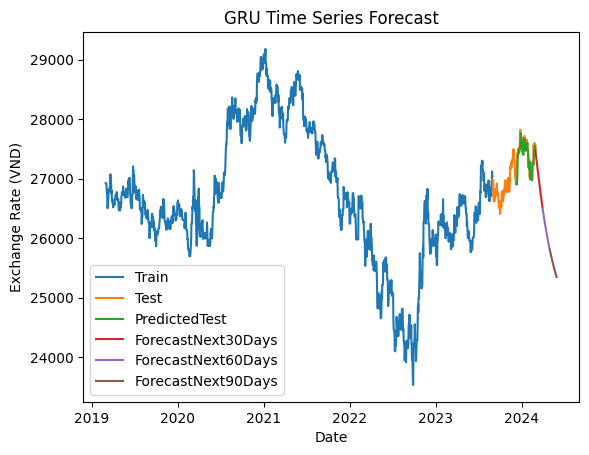

- Model accuracy evaluation: 
RMSE = 137.43585125932765
MAPE = 0.38271708662753273
MAE = 104.9698456554883


In [40]:
implementGRU(train_eur_3_sc, test_eur_3_sc)

**JPY_VND**

In [41]:
#### JPY - VND
jpy_sc = scaler.fit_transform(np.array(jpy).reshape(-1,1))
  # case 1. 7:3
train_jpy_1_sc = jpy_sc[:int(0.7*len(jpy))]
test_jpy_1_sc = jpy_sc[int(0.7*len(jpy)):]
  # case 2. 8:2
train_jpy_2_sc = jpy_sc[:int(0.8*len(jpy))]
test_jpy_2_sc = jpy_sc[int(0.8*len(jpy)):]
  # case 3. 9:1
train_jpy_3_sc = jpy_sc[:int(0.9*len(jpy))]
test_jpy_3_sc = jpy_sc[int(0.9*len(jpy)):]

* Case 7:3

Epoch 1/100


C:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


19/19 ━━━━━━━━━━━━━━━━━━━━ 3s 55ms/step - loss: 0.4030 - val_loss: 0.0609
Epoch 2/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step - loss: 0.0220 - val_loss: 0.0309
Epoch 3/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 48ms/step - loss: 0.0074 - val_loss: 0.0348
Epoch 4/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 43ms/step - loss: 0.0048 - val_loss: 0.0268
Epoch 5/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - loss: 0.0036 - val_loss: 0.0218
Epoch 6/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - loss: 0.0028 - val_loss: 0.0160
Epoch 7/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step - loss: 0.0022 - val_loss: 0.0112
Epoch 8/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - loss: 0.0017 - val_loss: 0.0074
Epoch 9/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - loss: 0.0012 - val_loss: 0.0045
Epoch 10/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - loss: 9.1669e-04 - val_loss: 0.0026
Epoch 11/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - loss: 6.6998e-04 - val_loss: 0.0014
Epoch 12/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - l

4 day output [[0.0532054]]
5 day input [0.04139259 0.06160757 0.06898765 0.0612867  0.0612867  0.0612867
 0.07684903 0.07091288 0.06866677 0.10717151 0.12000642 0.12000642
 0.12000642 0.08471041 0.10075405 0.09337398 0.17182737 0.17054388
 0.17054388 0.17054388 0.16877908 0.13043478 0.14631798 0.15129151
 0.15963421 0.15963421 0.15963421 0.15754853 0.16348468 0.16300337
 0.18626665 0.17006257 0.17006257 0.17006257 0.18305792 0.18145355
 0.16781646 0.14310926 0.11856249 0.11856249 0.11856249 0.12754693
 0.1384566  0.12642387 0.12145034 0.13396438 0.13396438 0.13396438
 0.12112947 0.11070111 0.08406867 0.08535216 0.08390823 0.08390823
 0.08390823 0.08214343 0.09112787 0.09898925 0.09754532 0.09401572
 0.09401572 0.09401572 0.08615434 0.07781165 0.08118081 0.08968394
 0.08454998 0.08454998 0.08454998 0.05647361 0.0524627  0.07059201
 0.05888015 0.04684742 0.04684742 0.04684742 0.0506979  0.04251564
 0.02583026 0.03818386 0.0454035  0.0454035  0.0454035  0.04957484
 0.04219477 0.04524306 0

13 day output [[0.05539474]]
14 day input [0.10717151 0.12000642 0.12000642 0.12000642 0.08471041 0.10075405
 0.09337398 0.17182737 0.17054388 0.17054388 0.17054388 0.16877908
 0.13043478 0.14631798 0.15129151 0.15963421 0.15963421 0.15963421
 0.15754853 0.16348468 0.16300337 0.18626665 0.17006257 0.17006257
 0.17006257 0.18305792 0.18145355 0.16781646 0.14310926 0.11856249
 0.11856249 0.11856249 0.12754693 0.1384566  0.12642387 0.12145034
 0.13396438 0.13396438 0.13396438 0.12112947 0.11070111 0.08406867
 0.08535216 0.08390823 0.08390823 0.08390823 0.08214343 0.09112787
 0.09898925 0.09754532 0.09401572 0.09401572 0.09401572 0.08615434
 0.07781165 0.08118081 0.08968394 0.08454998 0.08454998 0.08454998
 0.05647361 0.0524627  0.07059201 0.05888015 0.04684742 0.04684742
 0.04684742 0.0506979  0.04251564 0.02583026 0.03818386 0.0454035
 0.0454035  0.0454035  0.04957484 0.04219477 0.04524306 0.05053746
 0.04989572 0.04989572 0.04989572 0.05519012 0.05310444 0.04412001
 0.06369325 0.0470078

23 day output [[0.05769249]]
24 day input [0.17054388 0.16877908 0.13043478 0.14631798 0.15129151 0.15963421
 0.15963421 0.15963421 0.15754853 0.16348468 0.16300337 0.18626665
 0.17006257 0.17006257 0.17006257 0.18305792 0.18145355 0.16781646
 0.14310926 0.11856249 0.11856249 0.11856249 0.12754693 0.1384566
 0.12642387 0.12145034 0.13396438 0.13396438 0.13396438 0.12112947
 0.11070111 0.08406867 0.08535216 0.08390823 0.08390823 0.08390823
 0.08214343 0.09112787 0.09898925 0.09754532 0.09401572 0.09401572
 0.09401572 0.08615434 0.07781165 0.08118081 0.08968394 0.08454998
 0.08454998 0.08454998 0.05647361 0.0524627  0.07059201 0.05888015
 0.04684742 0.04684742 0.04684742 0.0506979  0.04251564 0.02583026
 0.03818386 0.0454035  0.0454035  0.0454035  0.04957484 0.04219477
 0.04524306 0.05053746 0.04989572 0.04989572 0.04989572 0.05519012
 0.05310444 0.04412001 0.06369325 0.04700786 0.0523697  0.05250214
 0.05271913 0.0529591  0.0532054  0.05345307 0.05370041 0.05394673
 0.05419173 0.0544353

33 day output [[0.05985544]]
34 day input [0.16300337 0.18626665 0.17006257 0.17006257 0.17006257 0.18305792
 0.18145355 0.16781646 0.14310926 0.11856249 0.11856249 0.11856249
 0.12754693 0.1384566  0.12642387 0.12145034 0.13396438 0.13396438
 0.13396438 0.12112947 0.11070111 0.08406867 0.08535216 0.08390823
 0.08390823 0.08390823 0.08214343 0.09112787 0.09898925 0.09754532
 0.09401572 0.09401572 0.09401572 0.08615434 0.07781165 0.08118081
 0.08968394 0.08454998 0.08454998 0.08454998 0.05647361 0.0524627
 0.07059201 0.05888015 0.04684742 0.04684742 0.04684742 0.0506979
 0.04251564 0.02583026 0.03818386 0.0454035  0.0454035  0.0454035
 0.04957484 0.04219477 0.04524306 0.05053746 0.04989572 0.04989572
 0.04989572 0.05519012 0.05310444 0.04412001 0.06369325 0.04700786
 0.0523697  0.05250214 0.05271913 0.0529591  0.0532054  0.05345307
 0.05370041 0.05394673 0.05419173 0.0544353  0.0546774  0.054918
 0.05515711 0.05539474 0.0556309  0.05586559 0.05609886 0.0563307
 0.05656113 0.05679015 0.0

43 day output [[0.06189311]]
44 day input [0.11856249 0.11856249 0.12754693 0.1384566  0.12642387 0.12145034
 0.13396438 0.13396438 0.13396438 0.12112947 0.11070111 0.08406867
 0.08535216 0.08390823 0.08390823 0.08390823 0.08214343 0.09112787
 0.09898925 0.09754532 0.09401572 0.09401572 0.09401572 0.08615434
 0.07781165 0.08118081 0.08968394 0.08454998 0.08454998 0.08454998
 0.05647361 0.0524627  0.07059201 0.05888015 0.04684742 0.04684742
 0.04684742 0.0506979  0.04251564 0.02583026 0.03818386 0.0454035
 0.0454035  0.0454035  0.04957484 0.04219477 0.04524306 0.05053746
 0.04989572 0.04989572 0.04989572 0.05519012 0.05310444 0.04412001
 0.06369325 0.04700786 0.0523697  0.05250214 0.05271913 0.0529591
 0.0532054  0.05345307 0.05370041 0.05394673 0.05419173 0.0544353
 0.0546774  0.054918   0.05515711 0.05539474 0.0556309  0.05586559
 0.05609886 0.0563307  0.05656113 0.05679015 0.0570178  0.05724407
 0.05746895 0.05769249 0.05791467 0.05813553 0.05835507 0.05857328
 0.05879018 0.05900579 

53 day output [[0.06381402]]
54 day input [0.11070111 0.08406867 0.08535216 0.08390823 0.08390823 0.08390823
 0.08214343 0.09112787 0.09898925 0.09754532 0.09401572 0.09401572
 0.09401572 0.08615434 0.07781165 0.08118081 0.08968394 0.08454998
 0.08454998 0.08454998 0.05647361 0.0524627  0.07059201 0.05888015
 0.04684742 0.04684742 0.04684742 0.0506979  0.04251564 0.02583026
 0.03818386 0.0454035  0.0454035  0.0454035  0.04957484 0.04219477
 0.04524306 0.05053746 0.04989572 0.04989572 0.04989572 0.05519012
 0.05310444 0.04412001 0.06369325 0.04700786 0.0523697  0.05250214
 0.05271913 0.0529591  0.0532054  0.05345307 0.05370041 0.05394673
 0.05419173 0.0544353  0.0546774  0.054918   0.05515711 0.05539474
 0.0556309  0.05586559 0.05609886 0.0563307  0.05656113 0.05679015
 0.0570178  0.05724407 0.05746895 0.05769249 0.05791467 0.05813553
 0.05835507 0.05857328 0.05879018 0.05900579 0.05922011 0.05943315
 0.05964493 0.05985544 0.06006469 0.06027271 0.06047948 0.06068505
 0.06088939 0.061092

63 day output [[0.06562583]]
64 day input [0.09401572 0.09401572 0.09401572 0.08615434 0.07781165 0.08118081
 0.08968394 0.08454998 0.08454998 0.08454998 0.05647361 0.0524627
 0.07059201 0.05888015 0.04684742 0.04684742 0.04684742 0.0506979
 0.04251564 0.02583026 0.03818386 0.0454035  0.0454035  0.0454035
 0.04957484 0.04219477 0.04524306 0.05053746 0.04989572 0.04989572
 0.04989572 0.05519012 0.05310444 0.04412001 0.06369325 0.04700786
 0.0523697  0.05250214 0.05271913 0.0529591  0.0532054  0.05345307
 0.05370041 0.05394673 0.05419173 0.0544353  0.0546774  0.054918
 0.05515711 0.05539474 0.0556309  0.05586559 0.05609886 0.0563307
 0.05656113 0.05679015 0.0570178  0.05724407 0.05746895 0.05769249
 0.05791467 0.05813553 0.05835507 0.05857328 0.05879018 0.05900579
 0.05922011 0.05943315 0.05964493 0.05985544 0.06006469 0.06027271
 0.06047948 0.06068505 0.06088939 0.06109252 0.06129444 0.06149517
 0.06169473 0.06189311 0.06209033 0.06228638 0.06248128 0.06267504
 0.06286766 0.06305915 0.0

73 day output [[0.06733571]]
74 day input [0.05647361 0.0524627  0.07059201 0.05888015 0.04684742 0.04684742
 0.04684742 0.0506979  0.04251564 0.02583026 0.03818386 0.0454035
 0.0454035  0.0454035  0.04957484 0.04219477 0.04524306 0.05053746
 0.04989572 0.04989572 0.04989572 0.05519012 0.05310444 0.04412001
 0.06369325 0.04700786 0.0523697  0.05250214 0.05271913 0.0529591
 0.0532054  0.05345307 0.05370041 0.05394673 0.05419173 0.0544353
 0.0546774  0.054918   0.05515711 0.05539474 0.0556309  0.05586559
 0.05609886 0.0563307  0.05656113 0.05679015 0.0570178  0.05724407
 0.05746895 0.05769249 0.05791467 0.05813553 0.05835507 0.05857328
 0.05879018 0.05900579 0.05922011 0.05943315 0.05964493 0.05985544
 0.06006469 0.06027271 0.06047948 0.06068505 0.06088939 0.06109252
 0.06129444 0.06149517 0.06169473 0.06189311 0.06209033 0.06228638
 0.06248128 0.06267504 0.06286766 0.06305915 0.06324953 0.06343879
 0.06362696 0.06381402 0.06399998 0.06418487 0.06436868 0.06455143
 0.0647331  0.06491373 

83 day output [[0.06895023]]
84 day input [0.03818386 0.0454035  0.0454035  0.0454035  0.04957484 0.04219477
 0.04524306 0.05053746 0.04989572 0.04989572 0.04989572 0.05519012
 0.05310444 0.04412001 0.06369325 0.04700786 0.0523697  0.05250214
 0.05271913 0.0529591  0.0532054  0.05345307 0.05370041 0.05394673
 0.05419173 0.0544353  0.0546774  0.054918   0.05515711 0.05539474
 0.0556309  0.05586559 0.05609886 0.0563307  0.05656113 0.05679015
 0.0570178  0.05724407 0.05746895 0.05769249 0.05791467 0.05813553
 0.05835507 0.05857328 0.05879018 0.05900579 0.05922011 0.05943315
 0.05964493 0.05985544 0.06006469 0.06027271 0.06047948 0.06068505
 0.06088939 0.06109252 0.06129444 0.06149517 0.06169473 0.06189311
 0.06209033 0.06228638 0.06248128 0.06267504 0.06286766 0.06305915
 0.06324953 0.06343879 0.06362696 0.06381402 0.06399998 0.06418487
 0.06436868 0.06455143 0.0647331  0.06491373 0.0650933  0.06527183
 0.06544934 0.06562583 0.06580129 0.06597574 0.06614919 0.06632165
 0.06649309 0.066663

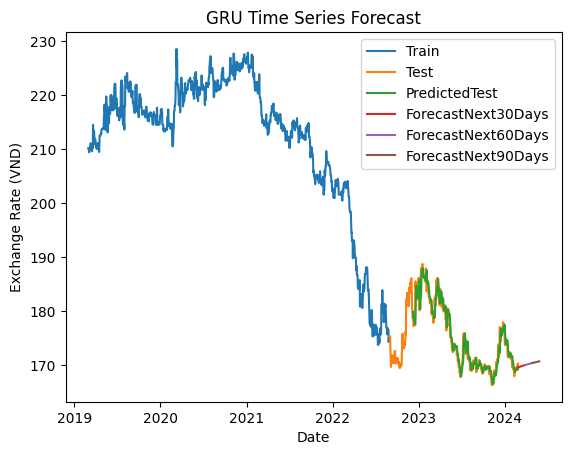

- Model accuracy evaluation: 
RMSE = 1.4031772546576098
MAPE = 0.5495025355609474
MAE = 0.970571760139209


In [42]:
implementGRU(train_jpy_1_sc, test_jpy_1_sc)

* Case 8:2

Epoch 1/100


C:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


22/22 ━━━━━━━━━━━━━━━━━━━━ 2s 54ms/step - loss: 0.3385 - val_loss: 0.1079
Epoch 2/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - loss: 0.0259 - val_loss: 0.0392
Epoch 3/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step - loss: 0.0098 - val_loss: 0.0351
Epoch 4/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - loss: 0.0068 - val_loss: 0.0211
Epoch 5/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step - loss: 0.0037 - val_loss: 0.0095
Epoch 6/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step - loss: 0.0019 - val_loss: 0.0033
Epoch 7/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - loss: 9.1086e-04 - val_loss: 9.5630e-04
Epoch 8/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - loss: 5.8732e-04 - val_loss: 4.5177e-04
Epoch 9/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step - loss: 5.6768e-04 - val_loss: 3.5953e-04
Epoch 10/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step - loss: 5.5612e-04 - val_loss: 3.6465e-04
Epoch 11/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step - loss: 4.8622e-04 - val_loss: 3.5955e-04
Epoch 12/100
22/22 ━━━━━

22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step - loss: 3.9312e-04 - val_loss: 2.3234e-04
Epoch 66/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - loss: 3.4972e-04 - val_loss: 2.4183e-04
Epoch 67/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step - loss: 3.6941e-04 - val_loss: 2.4044e-04
Epoch 68/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step - loss: 3.6153e-04 - val_loss: 2.3474e-04
Epoch 69/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - loss: 3.3680e-04 - val_loss: 2.4713e-04
Epoch 70/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step - loss: 3.3600e-04 - val_loss: 2.5815e-04
Epoch 71/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step - loss: 4.0564e-04 - val_loss: 2.5414e-04
Epoch 72/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step - loss: 3.3372e-04 - val_loss: 2.3149e-04
Epoch 73/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step - loss: 3.3719e-04 - val_loss: 2.2485e-04
Epoch 74/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step - loss: 3.3148e-04 - val_loss: 2.2701e-04
Epoch 75/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step - loss: 3.

4 day output [[0.0566548]]
5 day input [0.04139259 0.06160757 0.06898765 0.0612867  0.0612867  0.0612867
 0.07684903 0.07091288 0.06866677 0.10717151 0.12000642 0.12000642
 0.12000642 0.08471041 0.10075405 0.09337398 0.17182737 0.17054388
 0.17054388 0.17054388 0.16877908 0.13043478 0.14631798 0.15129151
 0.15963421 0.15963421 0.15963421 0.15754853 0.16348468 0.16300337
 0.18626665 0.17006257 0.17006257 0.17006257 0.18305792 0.18145355
 0.16781646 0.14310926 0.11856249 0.11856249 0.11856249 0.12754693
 0.1384566  0.12642387 0.12145034 0.13396438 0.13396438 0.13396438
 0.12112947 0.11070111 0.08406867 0.08535216 0.08390823 0.08390823
 0.08390823 0.08214343 0.09112787 0.09898925 0.09754532 0.09401572
 0.09401572 0.09401572 0.08615434 0.07781165 0.08118081 0.08968394
 0.08454998 0.08454998 0.08454998 0.05647361 0.0524627  0.07059201
 0.05888015 0.04684742 0.04684742 0.04684742 0.0506979  0.04251564
 0.02583026 0.03818386 0.0454035  0.0454035  0.0454035  0.04957484
 0.04219477 0.04524306 0

14 day output [[0.06395046]]
15 day input [0.12000642 0.12000642 0.12000642 0.08471041 0.10075405 0.09337398
 0.17182737 0.17054388 0.17054388 0.17054388 0.16877908 0.13043478
 0.14631798 0.15129151 0.15963421 0.15963421 0.15963421 0.15754853
 0.16348468 0.16300337 0.18626665 0.17006257 0.17006257 0.17006257
 0.18305792 0.18145355 0.16781646 0.14310926 0.11856249 0.11856249
 0.11856249 0.12754693 0.1384566  0.12642387 0.12145034 0.13396438
 0.13396438 0.13396438 0.12112947 0.11070111 0.08406867 0.08535216
 0.08390823 0.08390823 0.08390823 0.08214343 0.09112787 0.09898925
 0.09754532 0.09401572 0.09401572 0.09401572 0.08615434 0.07781165
 0.08118081 0.08968394 0.08454998 0.08454998 0.08454998 0.05647361
 0.0524627  0.07059201 0.05888015 0.04684742 0.04684742 0.04684742
 0.0506979  0.04251564 0.02583026 0.03818386 0.0454035  0.0454035
 0.0454035  0.04957484 0.04219477 0.04524306 0.05053746 0.04989572
 0.04989572 0.04989572 0.05519012 0.05310444 0.04412001 0.06369325
 0.04700786 0.0538996

24 day output [[0.07000842]]
25 day input [0.16877908 0.13043478 0.14631798 0.15129151 0.15963421 0.15963421
 0.15963421 0.15754853 0.16348468 0.16300337 0.18626665 0.17006257
 0.17006257 0.17006257 0.18305792 0.18145355 0.16781646 0.14310926
 0.11856249 0.11856249 0.11856249 0.12754693 0.1384566  0.12642387
 0.12145034 0.13396438 0.13396438 0.13396438 0.12112947 0.11070111
 0.08406867 0.08535216 0.08390823 0.08390823 0.08390823 0.08214343
 0.09112787 0.09898925 0.09754532 0.09401572 0.09401572 0.09401572
 0.08615434 0.07781165 0.08118081 0.08968394 0.08454998 0.08454998
 0.08454998 0.05647361 0.0524627  0.07059201 0.05888015 0.04684742
 0.04684742 0.04684742 0.0506979  0.04251564 0.02583026 0.03818386
 0.0454035  0.0454035  0.0454035  0.04957484 0.04219477 0.04524306
 0.05053746 0.04989572 0.04989572 0.04989572 0.05519012 0.05310444
 0.04412001 0.06369325 0.04700786 0.05389962 0.05434257 0.05505705
 0.05585016 0.0566548  0.05744937 0.05822904 0.05899327 0.05974252
 0.06047732 0.061198

34 day output [[0.07506294]]
35 day input [0.18626665 0.17006257 0.17006257 0.17006257 0.18305792 0.18145355
 0.16781646 0.14310926 0.11856249 0.11856249 0.11856249 0.12754693
 0.1384566  0.12642387 0.12145034 0.13396438 0.13396438 0.13396438
 0.12112947 0.11070111 0.08406867 0.08535216 0.08390823 0.08390823
 0.08390823 0.08214343 0.09112787 0.09898925 0.09754532 0.09401572
 0.09401572 0.09401572 0.08615434 0.07781165 0.08118081 0.08968394
 0.08454998 0.08454998 0.08454998 0.05647361 0.0524627  0.07059201
 0.05888015 0.04684742 0.04684742 0.04684742 0.0506979  0.04251564
 0.02583026 0.03818386 0.0454035  0.0454035  0.0454035  0.04957484
 0.04219477 0.04524306 0.05053746 0.04989572 0.04989572 0.04989572
 0.05519012 0.05310444 0.04412001 0.06369325 0.04700786 0.05389962
 0.05434257 0.05505705 0.05585016 0.0566548  0.05744937 0.05822904
 0.05899327 0.05974252 0.06047732 0.06119822 0.06190563 0.06259992
 0.06328144 0.06395046 0.06460728 0.06525215 0.0658853  0.06650697
 0.06711741 0.067716

44 day output [[0.07928984]]
45 day input [0.11856249 0.12754693 0.1384566  0.12642387 0.12145034 0.13396438
 0.13396438 0.13396438 0.12112947 0.11070111 0.08406867 0.08535216
 0.08390823 0.08390823 0.08390823 0.08214343 0.09112787 0.09898925
 0.09754532 0.09401572 0.09401572 0.09401572 0.08615434 0.07781165
 0.08118081 0.08968394 0.08454998 0.08454998 0.08454998 0.05647361
 0.0524627  0.07059201 0.05888015 0.04684742 0.04684742 0.04684742
 0.0506979  0.04251564 0.02583026 0.03818386 0.0454035  0.0454035
 0.0454035  0.04957484 0.04219477 0.04524306 0.05053746 0.04989572
 0.04989572 0.04989572 0.05519012 0.05310444 0.04412001 0.06369325
 0.04700786 0.05389962 0.05434257 0.05505705 0.05585016 0.0566548
 0.05744937 0.05822904 0.05899327 0.05974252 0.06047732 0.06119822
 0.06190563 0.06259992 0.06328144 0.06395046 0.06460728 0.06525215
 0.0658853  0.06650697 0.06711741 0.06771681 0.0683054  0.0688834
 0.069451   0.07000842 0.07055582 0.07109343 0.07162141 0.07213995
 0.07264926 0.07314946 

54 day output [[0.08283177]]
55 day input [0.08406867 0.08535216 0.08390823 0.08390823 0.08390823 0.08214343
 0.09112787 0.09898925 0.09754532 0.09401572 0.09401572 0.09401572
 0.08615434 0.07781165 0.08118081 0.08968394 0.08454998 0.08454998
 0.08454998 0.05647361 0.0524627  0.07059201 0.05888015 0.04684742
 0.04684742 0.04684742 0.0506979  0.04251564 0.02583026 0.03818386
 0.0454035  0.0454035  0.0454035  0.04957484 0.04219477 0.04524306
 0.05053746 0.04989572 0.04989572 0.04989572 0.05519012 0.05310444
 0.04412001 0.06369325 0.04700786 0.05389962 0.05434257 0.05505705
 0.05585016 0.0566548  0.05744937 0.05822904 0.05899327 0.05974252
 0.06047732 0.06119822 0.06190563 0.06259992 0.06328144 0.06395046
 0.06460728 0.06525215 0.0658853  0.06650697 0.06711741 0.06771681
 0.0683054  0.0688834  0.069451   0.07000842 0.07055582 0.07109343
 0.07162141 0.07213995 0.07264926 0.07314946 0.07364077 0.07412333
 0.07459734 0.07506294 0.07552028 0.07596952 0.07641084 0.07684436
 0.07727023 0.077688

63 day output [[0.08553022]]
64 day input [0.09401572 0.09401572 0.09401572 0.08615434 0.07781165 0.08118081
 0.08968394 0.08454998 0.08454998 0.08454998 0.05647361 0.0524627
 0.07059201 0.05888015 0.04684742 0.04684742 0.04684742 0.0506979
 0.04251564 0.02583026 0.03818386 0.0454035  0.0454035  0.0454035
 0.04957484 0.04219477 0.04524306 0.05053746 0.04989572 0.04989572
 0.04989572 0.05519012 0.05310444 0.04412001 0.06369325 0.04700786
 0.05389962 0.05434257 0.05505705 0.05585016 0.0566548  0.05744937
 0.05822904 0.05899327 0.05974252 0.06047732 0.06119822 0.06190563
 0.06259992 0.06328144 0.06395046 0.06460728 0.06525215 0.0658853
 0.06650697 0.06711741 0.06771681 0.0683054  0.0688834  0.069451
 0.07000842 0.07055582 0.07109343 0.07162141 0.07213995 0.07264926
 0.07314946 0.07364077 0.07412333 0.07459734 0.07506294 0.07552028
 0.07596952 0.07641084 0.07684436 0.07727023 0.07768861 0.07809962
 0.0785034  0.07890012 0.07928984 0.07967277 0.08004897 0.0804186
 0.08078177 0.08113862 0.08

73 day output [[0.0880729]]
74 day input [0.05647361 0.0524627  0.07059201 0.05888015 0.04684742 0.04684742
 0.04684742 0.0506979  0.04251564 0.02583026 0.03818386 0.0454035
 0.0454035  0.0454035  0.04957484 0.04219477 0.04524306 0.05053746
 0.04989572 0.04989572 0.04989572 0.05519012 0.05310444 0.04412001
 0.06369325 0.04700786 0.05389962 0.05434257 0.05505705 0.05585016
 0.0566548  0.05744937 0.05822904 0.05899327 0.05974252 0.06047732
 0.06119822 0.06190563 0.06259992 0.06328144 0.06395046 0.06460728
 0.06525215 0.0658853  0.06650697 0.06711741 0.06771681 0.0683054
 0.0688834  0.069451   0.07000842 0.07055582 0.07109343 0.07162141
 0.07213995 0.07264926 0.07314946 0.07364077 0.07412333 0.07459734
 0.07506294 0.07552028 0.07596952 0.07641084 0.07684436 0.07727023
 0.07768861 0.07809962 0.0785034  0.07890012 0.07928984 0.07967277
 0.08004897 0.0804186  0.08078177 0.08113862 0.08148925 0.08183376
 0.08217228 0.08250493 0.08283177 0.08315296 0.08346858 0.08377873
 0.08408351 0.08438301 

83 day output [[0.09021264]]
84 day input [0.03818386 0.0454035  0.0454035  0.0454035  0.04957484 0.04219477
 0.04524306 0.05053746 0.04989572 0.04989572 0.04989572 0.05519012
 0.05310444 0.04412001 0.06369325 0.04700786 0.05389962 0.05434257
 0.05505705 0.05585016 0.0566548  0.05744937 0.05822904 0.05899327
 0.05974252 0.06047732 0.06119822 0.06190563 0.06259992 0.06328144
 0.06395046 0.06460728 0.06525215 0.0658853  0.06650697 0.06711741
 0.06771681 0.0683054  0.0688834  0.069451   0.07000842 0.07055582
 0.07109343 0.07162141 0.07213995 0.07264926 0.07314946 0.07364077
 0.07412333 0.07459734 0.07506294 0.07552028 0.07596952 0.07641084
 0.07684436 0.07727023 0.07768861 0.07809962 0.0785034  0.07890012
 0.07928984 0.07967277 0.08004897 0.0804186  0.08078177 0.08113862
 0.08148925 0.08183376 0.08217228 0.08250493 0.08283177 0.08315296
 0.08346858 0.08377873 0.08408351 0.08438301 0.08467736 0.08496661
 0.08525086 0.08553022 0.08580478 0.0860746  0.08633978 0.08660041
 0.08685656 0.087108

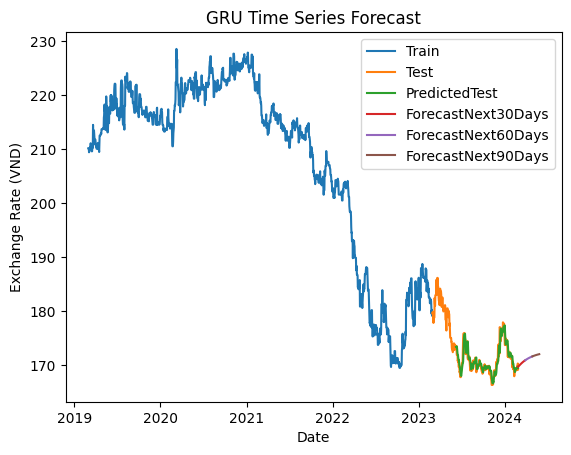

- Model accuracy evaluation: 
RMSE = 1.1494232103163993
MAPE = 0.4727631841719181
MAE = 0.8110162885261306


In [43]:
implementGRU(train_jpy_2_sc, test_jpy_2_sc)

* Case 9:1

Epoch 1/100


C:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 50ms/step - loss: 0.2053 - val_loss: 0.0465
Epoch 2/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 48ms/step - loss: 0.0116 - val_loss: 0.0152
Epoch 3/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step - loss: 0.0044 - val_loss: 0.0051
Epoch 4/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 48ms/step - loss: 0.0017 - val_loss: 0.0012
Epoch 5/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - loss: 6.3980e-04 - val_loss: 3.7124e-04
Epoch 6/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - loss: 5.1028e-04 - val_loss: 3.2605e-04
Epoch 7/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step - loss: 5.1416e-04 - val_loss: 3.2625e-04
Epoch 8/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step - loss: 5.1179e-04 - val_loss: 3.1759e-04
Epoch 9/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step - loss: 4.4349e-04 - val_loss: 3.1909e-04
Epoch 10/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - loss: 5.0519e-04 - val_loss: 3.1927e-04
Epoch 11/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - loss: 4.7083e-04 - val_loss: 3.1890e-04
Epoch 12

Epoch 65/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step - loss: 3.1662e-04 - val_loss: 2.3354e-04
Epoch 66/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step - loss: 3.0067e-04 - val_loss: 2.3616e-04
Epoch 67/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step - loss: 3.1120e-04 - val_loss: 2.3195e-04
Epoch 68/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - loss: 3.1869e-04 - val_loss: 2.3207e-04
Epoch 69/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - loss: 3.2195e-04 - val_loss: 2.3156e-04
Epoch 70/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - loss: 3.3382e-04 - val_loss: 2.4210e-04
Epoch 71/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 48ms/step - loss: 3.2131e-04 - val_loss: 2.3844e-04
Epoch 72/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step - loss: 2.9665e-04 - val_loss: 2.3816e-04
Epoch 73/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 43ms/step - loss: 3.3555e-04 - val_loss: 2.3247e-04
Epoch 74/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step - loss: 3.1991e-04 - val_loss: 2.5421e-04
Epoch 75/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/st

5 day output [[0.05075992]]
6 day input [0.06160757 0.06898765 0.0612867  0.0612867  0.0612867  0.07684903
 0.07091288 0.06866677 0.10717151 0.12000642 0.12000642 0.12000642
 0.08471041 0.10075405 0.09337398 0.17182737 0.17054388 0.17054388
 0.17054388 0.16877908 0.13043478 0.14631798 0.15129151 0.15963421
 0.15963421 0.15963421 0.15754853 0.16348468 0.16300337 0.18626665
 0.17006257 0.17006257 0.17006257 0.18305792 0.18145355 0.16781646
 0.14310926 0.11856249 0.11856249 0.11856249 0.12754693 0.1384566
 0.12642387 0.12145034 0.13396438 0.13396438 0.13396438 0.12112947
 0.11070111 0.08406867 0.08535216 0.08390823 0.08390823 0.08390823
 0.08214343 0.09112787 0.09898925 0.09754532 0.09401572 0.09401572
 0.09401572 0.08615434 0.07781165 0.08118081 0.08968394 0.08454998
 0.08454998 0.08454998 0.05647361 0.0524627  0.07059201 0.05888015
 0.04684742 0.04684742 0.04684742 0.0506979  0.04251564 0.02583026
 0.03818386 0.0454035  0.0454035  0.0454035  0.04957484 0.04219477
 0.04524306 0.05053746 

13 day output [[0.05034862]]
14 day input [0.10717151 0.12000642 0.12000642 0.12000642 0.08471041 0.10075405
 0.09337398 0.17182737 0.17054388 0.17054388 0.17054388 0.16877908
 0.13043478 0.14631798 0.15129151 0.15963421 0.15963421 0.15963421
 0.15754853 0.16348468 0.16300337 0.18626665 0.17006257 0.17006257
 0.17006257 0.18305792 0.18145355 0.16781646 0.14310926 0.11856249
 0.11856249 0.11856249 0.12754693 0.1384566  0.12642387 0.12145034
 0.13396438 0.13396438 0.13396438 0.12112947 0.11070111 0.08406867
 0.08535216 0.08390823 0.08390823 0.08390823 0.08214343 0.09112787
 0.09898925 0.09754532 0.09401572 0.09401572 0.09401572 0.08615434
 0.07781165 0.08118081 0.08968394 0.08454998 0.08454998 0.08454998
 0.05647361 0.0524627  0.07059201 0.05888015 0.04684742 0.04684742
 0.04684742 0.0506979  0.04251564 0.02583026 0.03818386 0.0454035
 0.0454035  0.0454035  0.04957484 0.04219477 0.04524306 0.05053746
 0.04989572 0.04989572 0.04989572 0.05519012 0.05310444 0.04412001
 0.06369325 0.0470078

23 day output [[0.04989216]]
24 day input [0.17054388 0.16877908 0.13043478 0.14631798 0.15129151 0.15963421
 0.15963421 0.15963421 0.15754853 0.16348468 0.16300337 0.18626665
 0.17006257 0.17006257 0.17006257 0.18305792 0.18145355 0.16781646
 0.14310926 0.11856249 0.11856249 0.11856249 0.12754693 0.1384566
 0.12642387 0.12145034 0.13396438 0.13396438 0.13396438 0.12112947
 0.11070111 0.08406867 0.08535216 0.08390823 0.08390823 0.08390823
 0.08214343 0.09112787 0.09898925 0.09754532 0.09401572 0.09401572
 0.09401572 0.08615434 0.07781165 0.08118081 0.08968394 0.08454998
 0.08454998 0.08454998 0.05647361 0.0524627  0.07059201 0.05888015
 0.04684742 0.04684742 0.04684742 0.0506979  0.04251564 0.02583026
 0.03818386 0.0454035  0.0454035  0.0454035  0.04957484 0.04219477
 0.04524306 0.05053746 0.04989572 0.04989572 0.04989572 0.05519012
 0.05310444 0.04412001 0.06369325 0.04700786 0.05139503 0.05108024
 0.05095615 0.05087861 0.05081651 0.05075992 0.05070567 0.05065269
 0.05060052 0.0505489

33 day output [[0.04949844]]
34 day input [0.16300337 0.18626665 0.17006257 0.17006257 0.17006257 0.18305792
 0.18145355 0.16781646 0.14310926 0.11856249 0.11856249 0.11856249
 0.12754693 0.1384566  0.12642387 0.12145034 0.13396438 0.13396438
 0.13396438 0.12112947 0.11070111 0.08406867 0.08535216 0.08390823
 0.08390823 0.08390823 0.08214343 0.09112787 0.09898925 0.09754532
 0.09401572 0.09401572 0.09401572 0.08615434 0.07781165 0.08118081
 0.08968394 0.08454998 0.08454998 0.08454998 0.05647361 0.0524627
 0.07059201 0.05888015 0.04684742 0.04684742 0.04684742 0.0506979
 0.04251564 0.02583026 0.03818386 0.0454035  0.0454035  0.0454035
 0.04957484 0.04219477 0.04524306 0.05053746 0.04989572 0.04989572
 0.04989572 0.05519012 0.05310444 0.04412001 0.06369325 0.04700786
 0.05139503 0.05108024 0.05095615 0.05087861 0.05081651 0.05075992
 0.05070567 0.05065269 0.05060052 0.05054899 0.05049802 0.05044763
 0.05039783 0.05034862 0.05030005 0.05025212 0.05020484 0.05015822
 0.05011224 0.05006693 

43 day output [[0.04916]]
44 day input [0.11856249 0.11856249 0.12754693 0.1384566  0.12642387 0.12145034
 0.13396438 0.13396438 0.13396438 0.12112947 0.11070111 0.08406867
 0.08535216 0.08390823 0.08390823 0.08390823 0.08214343 0.09112787
 0.09898925 0.09754532 0.09401572 0.09401572 0.09401572 0.08615434
 0.07781165 0.08118081 0.08968394 0.08454998 0.08454998 0.08454998
 0.05647361 0.0524627  0.07059201 0.05888015 0.04684742 0.04684742
 0.04684742 0.0506979  0.04251564 0.02583026 0.03818386 0.0454035
 0.0454035  0.0454035  0.04957484 0.04219477 0.04524306 0.05053746
 0.04989572 0.04989572 0.04989572 0.05519012 0.05310444 0.04412001
 0.06369325 0.04700786 0.05139503 0.05108024 0.05095615 0.05087861
 0.05081651 0.05075992 0.05070567 0.05065269 0.05060052 0.05054899
 0.05049802 0.05044763 0.05039783 0.05034862 0.05030005 0.05025212
 0.05020484 0.05015822 0.05011224 0.05006693 0.05002226 0.04997826
 0.04993489 0.04989216 0.04985008 0.04980861 0.04976775 0.04972751
 0.04968788 0.04964884 0

53 day output [[0.04886926]]
54 day input [0.11070111 0.08406867 0.08535216 0.08390823 0.08390823 0.08390823
 0.08214343 0.09112787 0.09898925 0.09754532 0.09401572 0.09401572
 0.09401572 0.08615434 0.07781165 0.08118081 0.08968394 0.08454998
 0.08454998 0.08454998 0.05647361 0.0524627  0.07059201 0.05888015
 0.04684742 0.04684742 0.04684742 0.0506979  0.04251564 0.02583026
 0.03818386 0.0454035  0.0454035  0.0454035  0.04957484 0.04219477
 0.04524306 0.05053746 0.04989572 0.04989572 0.04989572 0.05519012
 0.05310444 0.04412001 0.06369325 0.04700786 0.05139503 0.05108024
 0.05095615 0.05087861 0.05081651 0.05075992 0.05070567 0.05065269
 0.05060052 0.05054899 0.05049802 0.05044763 0.05039783 0.05034862
 0.05030005 0.05025212 0.05020484 0.05015822 0.05011224 0.05006693
 0.05002226 0.04997826 0.04993489 0.04989216 0.04985008 0.04980861
 0.04976775 0.04972751 0.04968788 0.04964884 0.04961038 0.04957251
 0.04953519 0.04949844 0.04946224 0.04942659 0.04939147 0.04935687
 0.04932279 0.049289

64 day output [[0.0485966]]
65 day input [0.09401572 0.09401572 0.08615434 0.07781165 0.08118081 0.08968394
 0.08454998 0.08454998 0.08454998 0.05647361 0.0524627  0.07059201
 0.05888015 0.04684742 0.04684742 0.04684742 0.0506979  0.04251564
 0.02583026 0.03818386 0.0454035  0.0454035  0.0454035  0.04957484
 0.04219477 0.04524306 0.05053746 0.04989572 0.04989572 0.04989572
 0.05519012 0.05310444 0.04412001 0.06369325 0.04700786 0.05139503
 0.05108024 0.05095615 0.05087861 0.05081651 0.05075992 0.05070567
 0.05065269 0.05060052 0.05054899 0.05049802 0.05044763 0.05039783
 0.05034862 0.05030005 0.05025212 0.05020484 0.05015822 0.05011224
 0.05006693 0.05002226 0.04997826 0.04993489 0.04989216 0.04985008
 0.04980861 0.04976775 0.04972751 0.04968788 0.04964884 0.04961038
 0.04957251 0.04953519 0.04949844 0.04946224 0.04942659 0.04939147
 0.04935687 0.04932279 0.04928924 0.04925619 0.04922364 0.04919159
 0.04916    0.04912889 0.04909828 0.04906809 0.04903838 0.04900911
 0.04898028 0.0489518

74 day output [[0.04838539]]
75 day input [0.0524627  0.07059201 0.05888015 0.04684742 0.04684742 0.04684742
 0.0506979  0.04251564 0.02583026 0.03818386 0.0454035  0.0454035
 0.0454035  0.04957484 0.04219477 0.04524306 0.05053746 0.04989572
 0.04989572 0.04989572 0.05519012 0.05310444 0.04412001 0.06369325
 0.04700786 0.05139503 0.05108024 0.05095615 0.05087861 0.05081651
 0.05075992 0.05070567 0.05065269 0.05060052 0.05054899 0.05049802
 0.05044763 0.05039783 0.05034862 0.05030005 0.05025212 0.05020484
 0.05015822 0.05011224 0.05006693 0.05002226 0.04997826 0.04993489
 0.04989216 0.04985008 0.04980861 0.04976775 0.04972751 0.04968788
 0.04964884 0.04961038 0.04957251 0.04953519 0.04949844 0.04946224
 0.04942659 0.04939147 0.04935687 0.04932279 0.04928924 0.04925619
 0.04922364 0.04919159 0.04916    0.04912889 0.04909828 0.04906809
 0.04903838 0.04900911 0.04898028 0.04895189 0.04892392 0.04889638
 0.04886926 0.04884253 0.04881623 0.04879031 0.04876478 0.04873964
 0.04871489 0.0486905

84 day output [[0.04820402]]
85 day input [0.0454035  0.0454035  0.0454035  0.04957484 0.04219477 0.04524306
 0.05053746 0.04989572 0.04989572 0.04989572 0.05519012 0.05310444
 0.04412001 0.06369325 0.04700786 0.05139503 0.05108024 0.05095615
 0.05087861 0.05081651 0.05075992 0.05070567 0.05065269 0.05060052
 0.05054899 0.05049802 0.05044763 0.05039783 0.05034862 0.05030005
 0.05025212 0.05020484 0.05015822 0.05011224 0.05006693 0.05002226
 0.04997826 0.04993489 0.04989216 0.04985008 0.04980861 0.04976775
 0.04972751 0.04968788 0.04964884 0.04961038 0.04957251 0.04953519
 0.04949844 0.04946224 0.04942659 0.04939147 0.04935687 0.04932279
 0.04928924 0.04925619 0.04922364 0.04919159 0.04916    0.04912889
 0.04909828 0.04906809 0.04903838 0.04900911 0.04898028 0.04895189
 0.04892392 0.04889638 0.04886926 0.04884253 0.04881623 0.04879031
 0.04876478 0.04873964 0.04871489 0.0486905  0.04866648 0.04864284
 0.04861953 0.0485966  0.048574   0.04855175 0.04852982 0.04850823
 0.04848697 0.048466

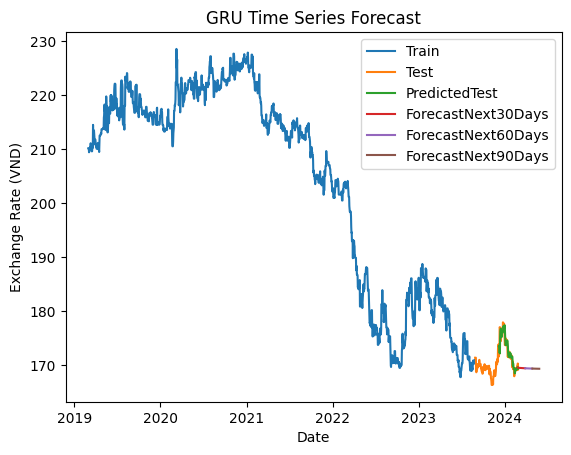

- Model accuracy evaluation: 
RMSE = 1.2123127812377525
MAPE = 0.4614660185796031
MAE = 0.8006442707340904


In [44]:
implementGRU(train_jpy_3_sc, test_jpy_3_sc)

**GBP_VND**

In [45]:
#### GBP - VND
gbp_sc = scaler.fit_transform(np.array(gbp).reshape(-1,1))
  # case 1. 7:3
train_gbp_1_sc = gbp_sc[:int(0.7*len(gbp))]
test_gbp_1_sc = gbp_sc[int(0.7*len(gbp)):]
  # case 2. 8:2
train_gbp_2_sc = gbp_sc[:int(0.8*len(gbp))]
test_gbp_2_sc = gbp_sc[int(0.8*len(gbp)):]
  # case 3. 9:1
train_gbp_3_sc = gbp_sc[:int(0.9*len(gbp))]
test_gbp_3_sc = gbp_sc[int(0.9*len(gbp)):]

* Case 7:3

Epoch 1/100


C:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


19/19 ━━━━━━━━━━━━━━━━━━━━ 2s 48ms/step - loss: 0.2313 - val_loss: 0.0311
Epoch 2/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - loss: 0.0194 - val_loss: 0.0046
Epoch 3/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 53ms/step - loss: 0.0065 - val_loss: 0.0030
Epoch 4/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - loss: 0.0041 - val_loss: 0.0017
Epoch 5/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step - loss: 0.0031 - val_loss: 0.0015
Epoch 6/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step - loss: 0.0025 - val_loss: 0.0011
Epoch 7/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step - loss: 0.0020 - val_loss: 9.4282e-04
Epoch 8/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step - loss: 0.0014 - val_loss: 7.5795e-04
Epoch 9/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 42ms/step - loss: 0.0012 - val_loss: 5.9805e-04
Epoch 10/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step - loss: 9.2542e-04 - val_loss: 5.4525e-04
Epoch 11/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step - loss: 8.6931e-04 - val_loss: 4.9349e-04
Epoch 12/100
19/19 ━━━━━━━━━━━━━━━━━

5 day output [[0.83738405]]
6 day input [0.75580126 0.75279825 0.75648376 0.75648376 0.75648376 0.74979525
 0.74105924 0.73027573 0.72167622 0.71048321 0.71048321 0.71048321
 0.71116571 0.71280371 0.70611521 0.74542725 0.78132678 0.78132678
 0.78132678 0.77354627 0.77764128 0.76180726 0.74938575 0.75593776
 0.75593776 0.75593776 0.75880426 0.76822277 0.78200928 0.79183729
 0.76535627 0.76535627 0.76535627 0.76931477 0.78924379 0.75812176
 0.78241878 0.76781327 0.76781327 0.76781327 0.76713077 0.78692329
 0.7959323  0.81094731 0.82350532 0.82350532 0.82350532 0.80644281
 0.79429429 0.78910729 0.8043953  0.8034398  0.8034398  0.8034398
 0.80985531 0.82295932 0.82555283 0.83114933 0.82241332 0.82241332
 0.82241332 0.80835381 0.77231777 0.78269178 0.76835927 0.78883429
 0.78883429 0.78883429 0.75279825 0.72836473 0.76194376 0.76412776
 0.76030576 0.76030576 0.76030576 0.76385476 0.76904177 0.73983074
 0.74406224 0.76999727 0.76999727 0.76999727 0.78228228 0.76972427
 0.77559378 0.81927382 

13 day output [[0.882873]]
14 day input [0.72167622 0.71048321 0.71048321 0.71048321 0.71116571 0.71280371
 0.70611521 0.74542725 0.78132678 0.78132678 0.78132678 0.77354627
 0.77764128 0.76180726 0.74938575 0.75593776 0.75593776 0.75593776
 0.75880426 0.76822277 0.78200928 0.79183729 0.76535627 0.76535627
 0.76535627 0.76931477 0.78924379 0.75812176 0.78241878 0.76781327
 0.76781327 0.76781327 0.76713077 0.78692329 0.7959323  0.81094731
 0.82350532 0.82350532 0.82350532 0.80644281 0.79429429 0.78910729
 0.8043953  0.8034398  0.8034398  0.8034398  0.80985531 0.82295932
 0.82555283 0.83114933 0.82241332 0.82241332 0.82241332 0.80835381
 0.77231777 0.78269178 0.76835927 0.78883429 0.78883429 0.78883429
 0.75279825 0.72836473 0.76194376 0.76412776 0.76030576 0.76030576
 0.76030576 0.76385476 0.76904177 0.73983074 0.74406224 0.76999727
 0.76999727 0.76999727 0.78228228 0.76972427 0.77559378 0.81927382
 0.82022932 0.82022932 0.82022932 0.82637183 0.82159432 0.8030303
 0.81572482 0.8030303  

23 day output [[0.94425976]]
24 day input [0.78132678 0.77354627 0.77764128 0.76180726 0.74938575 0.75593776
 0.75593776 0.75593776 0.75880426 0.76822277 0.78200928 0.79183729
 0.76535627 0.76535627 0.76535627 0.76931477 0.78924379 0.75812176
 0.78241878 0.76781327 0.76781327 0.76781327 0.76713077 0.78692329
 0.7959323  0.81094731 0.82350532 0.82350532 0.82350532 0.80644281
 0.79429429 0.78910729 0.8043953  0.8034398  0.8034398  0.8034398
 0.80985531 0.82295932 0.82555283 0.83114933 0.82241332 0.82241332
 0.82241332 0.80835381 0.77231777 0.78269178 0.76835927 0.78883429
 0.78883429 0.78883429 0.75279825 0.72836473 0.76194376 0.76412776
 0.76030576 0.76030576 0.76030576 0.76385476 0.76904177 0.73983074
 0.74406224 0.76999727 0.76999727 0.76999727 0.78228228 0.76972427
 0.77559378 0.81927382 0.82022932 0.82022932 0.82022932 0.82637183
 0.82159432 0.8030303  0.81572482 0.8030303  0.81245977 0.81655657
 0.82151276 0.82671428 0.83200628 0.83738405 0.84283882 0.84836739
 0.85396451 0.8596271

33 day output [[1.0090142]]
34 day input [0.78200928 0.79183729 0.76535627 0.76535627 0.76535627 0.76931477
 0.78924379 0.75812176 0.78241878 0.76781327 0.76781327 0.76781327
 0.76713077 0.78692329 0.7959323  0.81094731 0.82350532 0.82350532
 0.82350532 0.80644281 0.79429429 0.78910729 0.8043953  0.8034398
 0.8034398  0.8034398  0.80985531 0.82295932 0.82555283 0.83114933
 0.82241332 0.82241332 0.82241332 0.80835381 0.77231777 0.78269178
 0.76835927 0.78883429 0.78883429 0.78883429 0.75279825 0.72836473
 0.76194376 0.76412776 0.76030576 0.76030576 0.76030576 0.76385476
 0.76904177 0.73983074 0.74406224 0.76999727 0.76999727 0.76999727
 0.78228228 0.76972427 0.77559378 0.81927382 0.82022932 0.82022932
 0.82022932 0.82637183 0.82159432 0.8030303  0.81572482 0.8030303
 0.81245977 0.81655657 0.82151276 0.82671428 0.83200628 0.83738405
 0.84283882 0.84836739 0.85396451 0.85962713 0.8653518  0.87113613
 0.87697744 0.882873   0.88882011 0.89481646 0.90085846 0.90694481
 0.91307324 0.91924155 

41 day output [[1.0624588]]
42 day input [0.78241878 0.76781327 0.76781327 0.76781327 0.76713077 0.78692329
 0.7959323  0.81094731 0.82350532 0.82350532 0.82350532 0.80644281
 0.79429429 0.78910729 0.8043953  0.8034398  0.8034398  0.8034398
 0.80985531 0.82295932 0.82555283 0.83114933 0.82241332 0.82241332
 0.82241332 0.80835381 0.77231777 0.78269178 0.76835927 0.78883429
 0.78883429 0.78883429 0.75279825 0.72836473 0.76194376 0.76412776
 0.76030576 0.76030576 0.76030576 0.76385476 0.76904177 0.73983074
 0.74406224 0.76999727 0.76999727 0.76999727 0.78228228 0.76972427
 0.77559378 0.81927382 0.82022932 0.82022932 0.82022932 0.82637183
 0.82159432 0.8030303  0.81572482 0.8030303  0.81245977 0.81655657
 0.82151276 0.82671428 0.83200628 0.83738405 0.84283882 0.84836739
 0.85396451 0.85962713 0.8653518  0.87113613 0.87697744 0.882873
 0.88882011 0.89481646 0.90085846 0.90694481 0.91307324 0.91924155
 0.92544615 0.93168253 0.93795329 0.94425976 0.9506005  0.95697445
 0.96338081 0.96981966 0

51 day output [[1.1301626]]
52 day input [0.82350532 0.80644281 0.79429429 0.78910729 0.8043953  0.8034398
 0.8034398  0.8034398  0.80985531 0.82295932 0.82555283 0.83114933
 0.82241332 0.82241332 0.82241332 0.80835381 0.77231777 0.78269178
 0.76835927 0.78883429 0.78883429 0.78883429 0.75279825 0.72836473
 0.76194376 0.76412776 0.76030576 0.76030576 0.76030576 0.76385476
 0.76904177 0.73983074 0.74406224 0.76999727 0.76999727 0.76999727
 0.78228228 0.76972427 0.77559378 0.81927382 0.82022932 0.82022932
 0.82022932 0.82637183 0.82159432 0.8030303  0.81572482 0.8030303
 0.81245977 0.81655657 0.82151276 0.82671428 0.83200628 0.83738405
 0.84283882 0.84836739 0.85396451 0.85962713 0.8653518  0.87113613
 0.87697744 0.882873   0.88882011 0.89481646 0.90085846 0.90694481
 0.91307324 0.91924155 0.92544615 0.93168253 0.93795329 0.94425976
 0.9506005  0.95697445 0.96338081 0.96981966 0.97628784 0.9827829
 0.98930508 0.99585223 1.00242233 1.00901425 1.01562715 1.02226257
 1.02892101 1.03559732 1

60 day output [[1.1906544]]
61 day input [0.82295932 0.82555283 0.83114933 0.82241332 0.82241332 0.82241332
 0.80835381 0.77231777 0.78269178 0.76835927 0.78883429 0.78883429
 0.78883429 0.75279825 0.72836473 0.76194376 0.76412776 0.76030576
 0.76030576 0.76030576 0.76385476 0.76904177 0.73983074 0.74406224
 0.76999727 0.76999727 0.76999727 0.78228228 0.76972427 0.77559378
 0.81927382 0.82022932 0.82022932 0.82022932 0.82637183 0.82159432
 0.8030303  0.81572482 0.8030303  0.81245977 0.81655657 0.82151276
 0.82671428 0.83200628 0.83738405 0.84283882 0.84836739 0.85396451
 0.85962713 0.8653518  0.87113613 0.87697744 0.882873   0.88882011
 0.89481646 0.90085846 0.90694481 0.91307324 0.91924155 0.92544615
 0.93168253 0.93795329 0.94425976 0.9506005  0.95697445 0.96338081
 0.96981966 0.97628784 0.9827829  0.98930508 0.99585223 1.00242233
 1.00901425 1.01562715 1.02226257 1.02892101 1.03559732 1.04229021
 1.04899776 1.05571997 1.06245875 1.06920588 1.07596695 1.0827359
 1.08951128 1.09628963

69 day output [[1.2490828]]
70 day input [0.76835927 0.78883429 0.78883429 0.78883429 0.75279825 0.72836473
 0.76194376 0.76412776 0.76030576 0.76030576 0.76030576 0.76385476
 0.76904177 0.73983074 0.74406224 0.76999727 0.76999727 0.76999727
 0.78228228 0.76972427 0.77559378 0.81927382 0.82022932 0.82022932
 0.82022932 0.82637183 0.82159432 0.8030303  0.81572482 0.8030303
 0.81245977 0.81655657 0.82151276 0.82671428 0.83200628 0.83738405
 0.84283882 0.84836739 0.85396451 0.85962713 0.8653518  0.87113613
 0.87697744 0.882873   0.88882011 0.89481646 0.90085846 0.90694481
 0.91307324 0.91924155 0.92544615 0.93168253 0.93795329 0.94425976
 0.9506005  0.95697445 0.96338081 0.96981966 0.97628784 0.9827829
 0.98930508 0.99585223 1.00242233 1.00901425 1.01562715 1.02226257
 1.02892101 1.03559732 1.04229021 1.04899776 1.05571997 1.06245875
 1.06920588 1.07596695 1.0827359  1.08951128 1.09628963 1.10306752
 1.10984504 1.11661983 1.12339199 1.1301626  1.1369307  1.14369583
 1.15045321 1.15719783 

77 day output [[1.2978061]]
78 day input [0.76030576 0.76030576 0.76030576 0.76385476 0.76904177 0.73983074
 0.74406224 0.76999727 0.76999727 0.76999727 0.78228228 0.76972427
 0.77559378 0.81927382 0.82022932 0.82022932 0.82022932 0.82637183
 0.82159432 0.8030303  0.81572482 0.8030303  0.81245977 0.81655657
 0.82151276 0.82671428 0.83200628 0.83738405 0.84283882 0.84836739
 0.85396451 0.85962713 0.8653518  0.87113613 0.87697744 0.882873
 0.88882011 0.89481646 0.90085846 0.90694481 0.91307324 0.91924155
 0.92544615 0.93168253 0.93795329 0.94425976 0.9506005  0.95697445
 0.96338081 0.96981966 0.97628784 0.9827829  0.98930508 0.99585223
 1.00242233 1.00901425 1.01562715 1.02226257 1.02892101 1.03559732
 1.04229021 1.04899776 1.05571997 1.06245875 1.06920588 1.07596695
 1.0827359  1.08951128 1.09628963 1.10306752 1.10984504 1.11661983
 1.12339199 1.1301626  1.1369307  1.14369583 1.15045321 1.15719783
 1.16392624 1.17064011 1.1773349  1.18400764 1.1906544  1.19727325
 1.20386446 1.21042585 

87 day output [[1.3515948]]
88 day input [0.78228228 0.76972427 0.77559378 0.81927382 0.82022932 0.82022932
 0.82022932 0.82637183 0.82159432 0.8030303  0.81572482 0.8030303
 0.81245977 0.81655657 0.82151276 0.82671428 0.83200628 0.83738405
 0.84283882 0.84836739 0.85396451 0.85962713 0.8653518  0.87113613
 0.87697744 0.882873   0.88882011 0.89481646 0.90085846 0.90694481
 0.91307324 0.91924155 0.92544615 0.93168253 0.93795329 0.94425976
 0.9506005  0.95697445 0.96338081 0.96981966 0.97628784 0.9827829
 0.98930508 0.99585223 1.00242233 1.00901425 1.01562715 1.02226257
 1.02892101 1.03559732 1.04229021 1.04899776 1.05571997 1.06245875
 1.06920588 1.07596695 1.0827359  1.08951128 1.09628963 1.10306752
 1.10984504 1.11661983 1.12339199 1.1301626  1.1369307  1.14369583
 1.15045321 1.15719783 1.16392624 1.17064011 1.1773349  1.18400764
 1.1906544  1.19727325 1.20386446 1.21042585 1.21695697 1.22345364
 1.22991657 1.23634768 1.24274051 1.2490828  1.25537622 1.26161015
 1.26779318 1.27392435 

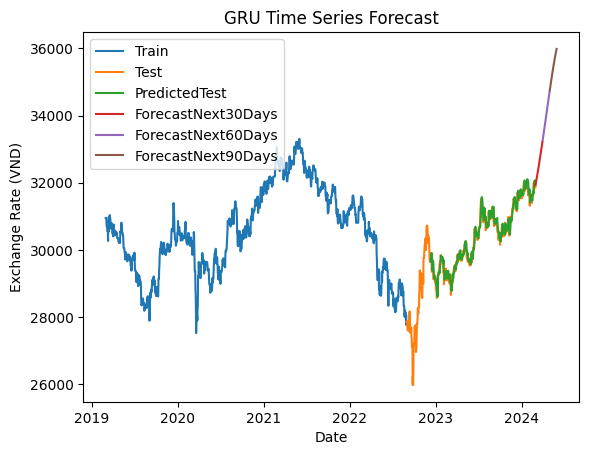

- Model accuracy evaluation: 
RMSE = 174.2330047462395
MAPE = 0.43711830536698243
MAE = 132.63739600810962


In [46]:
implementGRU(train_gbp_1_sc, test_gbp_1_sc)

* Case 8:2

Epoch 1/100


C:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


22/22 ━━━━━━━━━━━━━━━━━━━━ 2s 43ms/step - loss: 0.2998 - val_loss: 0.0188
Epoch 2/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - loss: 0.0196 - val_loss: 0.0067
Epoch 3/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 43ms/step - loss: 0.0064 - val_loss: 8.9131e-04
Epoch 4/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 42ms/step - loss: 0.0043 - val_loss: 0.0011
Epoch 5/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 43ms/step - loss: 0.0033 - val_loss: 9.0768e-04
Epoch 6/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step - loss: 0.0025 - val_loss: 8.3956e-04
Epoch 7/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step - loss: 0.0018 - val_loss: 5.3544e-04
Epoch 8/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - loss: 0.0013 - val_loss: 5.1789e-04
Epoch 9/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 53ms/step - loss: 9.9207e-04 - val_loss: 5.0359e-04
Epoch 10/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step - loss: 9.7691e-04 - val_loss: 4.6092e-04
Epoch 11/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step - loss: 8.6939e-04 - val_loss: 4.5493e-04
Epoch 12/100
22/22 ━

22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - loss: 5.4805e-04 - val_loss: 2.9906e-04
Epoch 66/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step - loss: 4.9035e-04 - val_loss: 3.0207e-04
Epoch 67/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step - loss: 4.7096e-04 - val_loss: 3.7660e-04
Epoch 68/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - loss: 5.4266e-04 - val_loss: 2.9503e-04
Epoch 69/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step - loss: 4.5532e-04 - val_loss: 3.1556e-04
Epoch 70/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step - loss: 4.6259e-04 - val_loss: 3.1244e-04
Epoch 71/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step - loss: 4.8553e-04 - val_loss: 3.1252e-04
Epoch 72/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step - loss: 4.8607e-04 - val_loss: 2.9653e-04
Epoch 73/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - loss: 5.2873e-04 - val_loss: 2.9172e-04
Epoch 74/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - loss: 5.0539e-04 - val_loss: 2.9293e-04
Epoch 75/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - loss: 5.

4 day output [[0.7825099]]
5 day input [0.73450723 0.75580126 0.75279825 0.75648376 0.75648376 0.75648376
 0.74979525 0.74105924 0.73027573 0.72167622 0.71048321 0.71048321
 0.71048321 0.71116571 0.71280371 0.70611521 0.74542725 0.78132678
 0.78132678 0.78132678 0.77354627 0.77764128 0.76180726 0.74938575
 0.75593776 0.75593776 0.75593776 0.75880426 0.76822277 0.78200928
 0.79183729 0.76535627 0.76535627 0.76535627 0.76931477 0.78924379
 0.75812176 0.78241878 0.76781327 0.76781327 0.76781327 0.76713077
 0.78692329 0.7959323  0.81094731 0.82350532 0.82350532 0.82350532
 0.80644281 0.79429429 0.78910729 0.8043953  0.8034398  0.8034398
 0.8034398  0.80985531 0.82295932 0.82555283 0.83114933 0.82241332
 0.82241332 0.82241332 0.80835381 0.77231777 0.78269178 0.76835927
 0.78883429 0.78883429 0.78883429 0.75279825 0.72836473 0.76194376
 0.76412776 0.76030576 0.76030576 0.76030576 0.76385476 0.76904177
 0.73983074 0.74406224 0.76999727 0.76999727 0.76999727 0.78228228
 0.76972427 0.77559378 0

14 day output [[0.73447996]]
15 day input [0.71048321 0.71048321 0.71048321 0.71116571 0.71280371 0.70611521
 0.74542725 0.78132678 0.78132678 0.78132678 0.77354627 0.77764128
 0.76180726 0.74938575 0.75593776 0.75593776 0.75593776 0.75880426
 0.76822277 0.78200928 0.79183729 0.76535627 0.76535627 0.76535627
 0.76931477 0.78924379 0.75812176 0.78241878 0.76781327 0.76781327
 0.76781327 0.76713077 0.78692329 0.7959323  0.81094731 0.82350532
 0.82350532 0.82350532 0.80644281 0.79429429 0.78910729 0.8043953
 0.8034398  0.8034398  0.8034398  0.80985531 0.82295932 0.82555283
 0.83114933 0.82241332 0.82241332 0.82241332 0.80835381 0.77231777
 0.78269178 0.76835927 0.78883429 0.78883429 0.78883429 0.75279825
 0.72836473 0.76194376 0.76412776 0.76030576 0.76030576 0.76030576
 0.76385476 0.76904177 0.73983074 0.74406224 0.76999727 0.76999727
 0.76999727 0.78228228 0.76972427 0.77559378 0.81927382 0.82022932
 0.82022932 0.82022932 0.82637183 0.82159432 0.8030303  0.81572482
 0.8030303  0.8006703

23 day output [[0.69031113]]
24 day input [0.78132678 0.77354627 0.77764128 0.76180726 0.74938575 0.75593776
 0.75593776 0.75593776 0.75880426 0.76822277 0.78200928 0.79183729
 0.76535627 0.76535627 0.76535627 0.76931477 0.78924379 0.75812176
 0.78241878 0.76781327 0.76781327 0.76781327 0.76713077 0.78692329
 0.7959323  0.81094731 0.82350532 0.82350532 0.82350532 0.80644281
 0.79429429 0.78910729 0.8043953  0.8034398  0.8034398  0.8034398
 0.80985531 0.82295932 0.82555283 0.83114933 0.82241332 0.82241332
 0.82241332 0.80835381 0.77231777 0.78269178 0.76835927 0.78883429
 0.78883429 0.78883429 0.75279825 0.72836473 0.76194376 0.76412776
 0.76030576 0.76030576 0.76030576 0.76385476 0.76904177 0.73983074
 0.74406224 0.76999727 0.76999727 0.76999727 0.78228228 0.76972427
 0.77559378 0.81927382 0.82022932 0.82022932 0.82022932 0.82637183
 0.82159432 0.8030303  0.81572482 0.8030303  0.80067033 0.79606503
 0.79161364 0.78709084 0.78250992 0.77787268 0.77318525 0.76845247
 0.76368022 0.7588728

33 day output [[0.6428048]]
34 day input [0.78200928 0.79183729 0.76535627 0.76535627 0.76535627 0.76931477
 0.78924379 0.75812176 0.78241878 0.76781327 0.76781327 0.76781327
 0.76713077 0.78692329 0.7959323  0.81094731 0.82350532 0.82350532
 0.82350532 0.80644281 0.79429429 0.78910729 0.8043953  0.8034398
 0.8034398  0.8034398  0.80985531 0.82295932 0.82555283 0.83114933
 0.82241332 0.82241332 0.82241332 0.80835381 0.77231777 0.78269178
 0.76835927 0.78883429 0.78883429 0.78883429 0.75279825 0.72836473
 0.76194376 0.76412776 0.76030576 0.76030576 0.76030576 0.76385476
 0.76904177 0.73983074 0.74406224 0.76999727 0.76999727 0.76999727
 0.78228228 0.76972427 0.77559378 0.81927382 0.82022932 0.82022932
 0.82022932 0.82637183 0.82159432 0.8030303  0.81572482 0.8030303
 0.80067033 0.79606503 0.79161364 0.78709084 0.78250992 0.77787268
 0.77318525 0.76845247 0.76368022 0.75887287 0.75403559 0.74917293
 0.74428988 0.73939067 0.73447996 0.72956145 0.72463924 0.71971631
 0.71479571 0.70988065 

43 day output [[0.5988394]]
44 day input [0.76781327 0.76781327 0.76713077 0.78692329 0.7959323  0.81094731
 0.82350532 0.82350532 0.82350532 0.80644281 0.79429429 0.78910729
 0.8043953  0.8034398  0.8034398  0.8034398  0.80985531 0.82295932
 0.82555283 0.83114933 0.82241332 0.82241332 0.82241332 0.80835381
 0.77231777 0.78269178 0.76835927 0.78883429 0.78883429 0.78883429
 0.75279825 0.72836473 0.76194376 0.76412776 0.76030576 0.76030576
 0.76030576 0.76385476 0.76904177 0.73983074 0.74406224 0.76999727
 0.76999727 0.76999727 0.78228228 0.76972427 0.77559378 0.81927382
 0.82022932 0.82022932 0.82022932 0.82637183 0.82159432 0.8030303
 0.81572482 0.8030303  0.80067033 0.79606503 0.79161364 0.78709084
 0.78250992 0.77787268 0.77318525 0.76845247 0.76368022 0.75887287
 0.75403559 0.74917293 0.74428988 0.73939067 0.73447996 0.72956145
 0.72463924 0.71971631 0.71479571 0.70988065 0.70497334 0.70007503
 0.69518667 0.69031113 0.68545061 0.68060833 0.67578638 0.67098773
 0.66621488 0.66146994

52 day output [[0.56318367]]
53 day input [0.80644281 0.79429429 0.78910729 0.8043953  0.8034398  0.8034398
 0.8034398  0.80985531 0.82295932 0.82555283 0.83114933 0.82241332
 0.82241332 0.82241332 0.80835381 0.77231777 0.78269178 0.76835927
 0.78883429 0.78883429 0.78883429 0.75279825 0.72836473 0.76194376
 0.76412776 0.76030576 0.76030576 0.76030576 0.76385476 0.76904177
 0.73983074 0.74406224 0.76999727 0.76999727 0.76999727 0.78228228
 0.76972427 0.77559378 0.81927382 0.82022932 0.82022932 0.82022932
 0.82637183 0.82159432 0.8030303  0.81572482 0.8030303  0.80067033
 0.79606503 0.79161364 0.78709084 0.78250992 0.77787268 0.77318525
 0.76845247 0.76368022 0.75887287 0.75403559 0.74917293 0.74428988
 0.73939067 0.73447996 0.72956145 0.72463924 0.71971631 0.71479571
 0.70988065 0.70497334 0.70007503 0.69518667 0.69031113 0.68545061
 0.68060833 0.67578638 0.67098773 0.66621488 0.66146994 0.65675467
 0.65207112 0.64742076 0.6428048  0.63822424 0.63368082 0.62917638
 0.62471282 0.6202908

62 day output [[0.5280614]]
63 day input [0.83114933 0.82241332 0.82241332 0.82241332 0.80835381 0.77231777
 0.78269178 0.76835927 0.78883429 0.78883429 0.78883429 0.75279825
 0.72836473 0.76194376 0.76412776 0.76030576 0.76030576 0.76030576
 0.76385476 0.76904177 0.73983074 0.74406224 0.76999727 0.76999727
 0.76999727 0.78228228 0.76972427 0.77559378 0.81927382 0.82022932
 0.82022932 0.82022932 0.82637183 0.82159432 0.8030303  0.81572482
 0.8030303  0.80067033 0.79606503 0.79161364 0.78709084 0.78250992
 0.77787268 0.77318525 0.76845247 0.76368022 0.75887287 0.75403559
 0.74917293 0.74428988 0.73939067 0.73447996 0.72956145 0.72463924
 0.71971631 0.71479571 0.70988065 0.70497334 0.70007503 0.69518667
 0.69031113 0.68545061 0.68060833 0.67578638 0.67098773 0.66621488
 0.66146994 0.65675467 0.65207112 0.64742076 0.6428048  0.63822424
 0.63368082 0.62917638 0.62471282 0.62029082 0.61591154 0.61157572
 0.60728437 0.60303879 0.5988394  0.5946874  0.59058273 0.58652616
 0.58251745 0.5785562

72 day output [[0.4973843]]
73 day input [0.78883429 0.75279825 0.72836473 0.76194376 0.76412776 0.76030576
 0.76030576 0.76030576 0.76385476 0.76904177 0.73983074 0.74406224
 0.76999727 0.76999727 0.76999727 0.78228228 0.76972427 0.77559378
 0.81927382 0.82022932 0.82022932 0.82022932 0.82637183 0.82159432
 0.8030303  0.81572482 0.8030303  0.80067033 0.79606503 0.79161364
 0.78709084 0.78250992 0.77787268 0.77318525 0.76845247 0.76368022
 0.75887287 0.75403559 0.74917293 0.74428988 0.73939067 0.73447996
 0.72956145 0.72463924 0.71971631 0.71479571 0.70988065 0.70497334
 0.70007503 0.69518667 0.69031113 0.68545061 0.68060833 0.67578638
 0.67098773 0.66621488 0.66146994 0.65675467 0.65207112 0.64742076
 0.6428048  0.63822424 0.63368082 0.62917638 0.62471282 0.62029082
 0.61591154 0.61157572 0.60728437 0.60303879 0.5988394  0.5946874
 0.59058273 0.58652616 0.58251745 0.57855624 0.57464248 0.57077563
 0.56695604 0.56318367 0.55945879 0.55578196 0.55215299 0.54857188
 0.54503769 0.54155058

82 day output [[0.47073632]]
83 day input [0.73983074 0.74406224 0.76999727 0.76999727 0.76999727 0.78228228
 0.76972427 0.77559378 0.81927382 0.82022932 0.82022932 0.82022932
 0.82637183 0.82159432 0.8030303  0.81572482 0.8030303  0.80067033
 0.79606503 0.79161364 0.78709084 0.78250992 0.77787268 0.77318525
 0.76845247 0.76368022 0.75887287 0.75403559 0.74917293 0.74428988
 0.73939067 0.73447996 0.72956145 0.72463924 0.71971631 0.71479571
 0.70988065 0.70497334 0.70007503 0.69518667 0.69031113 0.68545061
 0.68060833 0.67578638 0.67098773 0.66621488 0.66146994 0.65675467
 0.65207112 0.64742076 0.6428048  0.63822424 0.63368082 0.62917638
 0.62471282 0.62029082 0.61591154 0.61157572 0.60728437 0.60303879
 0.5988394  0.5946874  0.59058273 0.58652616 0.58251745 0.57855624
 0.57464248 0.57077563 0.56695604 0.56318367 0.55945879 0.55578196
 0.55215299 0.54857188 0.54503769 0.54155058 0.5381099  0.53471524
 0.53136605 0.52806139 0.52480096 0.52158409 0.51841056 0.51527989
 0.51219177 0.509146

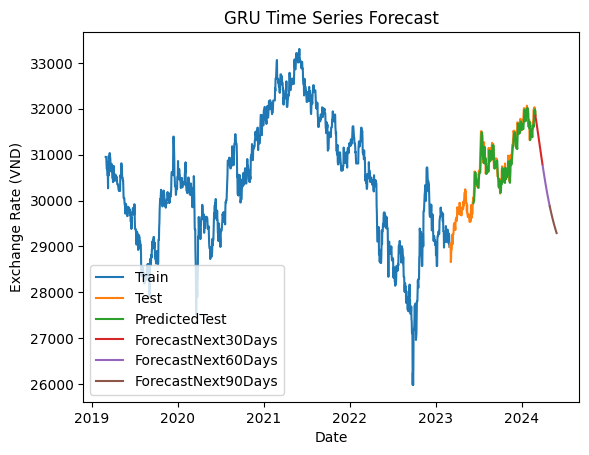

- Model accuracy evaluation: 
RMSE = 177.78423668628116
MAPE = 0.4353466923698681
MAE = 135.31843335700736


In [47]:
implementGRU(train_gbp_2_sc, test_gbp_2_sc)

* Case 9:1

Epoch 1/100


C:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 43ms/step - loss: 0.1982 - val_loss: 0.0044
Epoch 2/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - loss: 0.0087 - val_loss: 0.0042
Epoch 3/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - loss: 0.0043 - val_loss: 0.0032
Epoch 4/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - loss: 0.0034 - val_loss: 0.0011
Epoch 5/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - loss: 0.0024 - val_loss: 9.3607e-04
Epoch 6/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - loss: 0.0016 - val_loss: 6.4009e-04
Epoch 7/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - loss: 0.0010 - val_loss: 5.0040e-04
Epoch 8/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - loss: 9.6963e-04 - val_loss: 4.8601e-04
Epoch 9/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - loss: 7.5113e-04 - val_loss: 4.7490e-04
Epoch 10/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - loss: 7.8484e-04 - val_loss: 3.3458e-04
Epoch 11/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - loss: 6.9951e-04 - val_loss: 3.6447e-04
Epoch 12/100
25/25 ━

25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step - loss: 4.4475e-04 - val_loss: 3.5022e-04
Epoch 66/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - loss: 4.9828e-04 - val_loss: 2.4794e-04
Epoch 67/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - loss: 4.9126e-04 - val_loss: 2.4762e-04
Epoch 68/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - loss: 4.9585e-04 - val_loss: 2.4697e-04
Epoch 69/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - loss: 4.4066e-04 - val_loss: 2.4636e-04
Epoch 70/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - loss: 4.8972e-04 - val_loss: 2.5970e-04
Epoch 71/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - loss: 4.7676e-04 - val_loss: 2.8796e-04
Epoch 72/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - loss: 4.6338e-04 - val_loss: 2.5201e-04
Epoch 73/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - loss: 4.3225e-04 - val_loss: 2.4524e-04
Epoch 74/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - loss: 5.1751e-04 - val_loss: 2.4458e-04
Epoch 75/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - loss: 4.

5 day output [[0.78893226]]
6 day input [0.75580126 0.75279825 0.75648376 0.75648376 0.75648376 0.74979525
 0.74105924 0.73027573 0.72167622 0.71048321 0.71048321 0.71048321
 0.71116571 0.71280371 0.70611521 0.74542725 0.78132678 0.78132678
 0.78132678 0.77354627 0.77764128 0.76180726 0.74938575 0.75593776
 0.75593776 0.75593776 0.75880426 0.76822277 0.78200928 0.79183729
 0.76535627 0.76535627 0.76535627 0.76931477 0.78924379 0.75812176
 0.78241878 0.76781327 0.76781327 0.76781327 0.76713077 0.78692329
 0.7959323  0.81094731 0.82350532 0.82350532 0.82350532 0.80644281
 0.79429429 0.78910729 0.8043953  0.8034398  0.8034398  0.8034398
 0.80985531 0.82295932 0.82555283 0.83114933 0.82241332 0.82241332
 0.82241332 0.80835381 0.77231777 0.78269178 0.76835927 0.78883429
 0.78883429 0.78883429 0.75279825 0.72836473 0.76194376 0.76412776
 0.76030576 0.76030576 0.76030576 0.76385476 0.76904177 0.73983074
 0.74406224 0.76999727 0.76999727 0.76999727 0.78228228 0.76972427
 0.77559378 0.81927382 

14 day output [[0.7664519]]
15 day input [0.71048321 0.71048321 0.71048321 0.71116571 0.71280371 0.70611521
 0.74542725 0.78132678 0.78132678 0.78132678 0.77354627 0.77764128
 0.76180726 0.74938575 0.75593776 0.75593776 0.75593776 0.75880426
 0.76822277 0.78200928 0.79183729 0.76535627 0.76535627 0.76535627
 0.76931477 0.78924379 0.75812176 0.78241878 0.76781327 0.76781327
 0.76781327 0.76713077 0.78692329 0.7959323  0.81094731 0.82350532
 0.82350532 0.82350532 0.80644281 0.79429429 0.78910729 0.8043953
 0.8034398  0.8034398  0.8034398  0.80985531 0.82295932 0.82555283
 0.83114933 0.82241332 0.82241332 0.82241332 0.80835381 0.77231777
 0.78269178 0.76835927 0.78883429 0.78883429 0.78883429 0.75279825
 0.72836473 0.76194376 0.76412776 0.76030576 0.76030576 0.76030576
 0.76385476 0.76904177 0.73983074 0.74406224 0.76999727 0.76999727
 0.76999727 0.78228228 0.76972427 0.77559378 0.81927382 0.82022932
 0.82022932 0.82022932 0.82637183 0.82159432 0.8030303  0.81572482
 0.8030303  0.80273521

22 day output [[0.74746245]]
23 day input [0.78132678 0.78132678 0.77354627 0.77764128 0.76180726 0.74938575
 0.75593776 0.75593776 0.75593776 0.75880426 0.76822277 0.78200928
 0.79183729 0.76535627 0.76535627 0.76535627 0.76931477 0.78924379
 0.75812176 0.78241878 0.76781327 0.76781327 0.76781327 0.76713077
 0.78692329 0.7959323  0.81094731 0.82350532 0.82350532 0.82350532
 0.80644281 0.79429429 0.78910729 0.8043953  0.8034398  0.8034398
 0.8034398  0.80985531 0.82295932 0.82555283 0.83114933 0.82241332
 0.82241332 0.82241332 0.80835381 0.77231777 0.78269178 0.76835927
 0.78883429 0.78883429 0.78883429 0.75279825 0.72836473 0.76194376
 0.76412776 0.76030576 0.76030576 0.76030576 0.76385476 0.76904177
 0.73983074 0.74406224 0.76999727 0.76999727 0.76999727 0.78228228
 0.76972427 0.77559378 0.81927382 0.82022932 0.82022932 0.82022932
 0.82637183 0.82159432 0.8030303  0.81572482 0.8030303  0.80273521
 0.79947418 0.79677439 0.7941469  0.79152638 0.78893226 0.78635097
 0.78379482 0.7812563

32 day output [[0.72427255]]
33 day input [0.76822277 0.78200928 0.79183729 0.76535627 0.76535627 0.76535627
 0.76931477 0.78924379 0.75812176 0.78241878 0.76781327 0.76781327
 0.76781327 0.76713077 0.78692329 0.7959323  0.81094731 0.82350532
 0.82350532 0.82350532 0.80644281 0.79429429 0.78910729 0.8043953
 0.8034398  0.8034398  0.8034398  0.80985531 0.82295932 0.82555283
 0.83114933 0.82241332 0.82241332 0.82241332 0.80835381 0.77231777
 0.78269178 0.76835927 0.78883429 0.78883429 0.78883429 0.75279825
 0.72836473 0.76194376 0.76412776 0.76030576 0.76030576 0.76030576
 0.76385476 0.76904177 0.73983074 0.74406224 0.76999727 0.76999727
 0.76999727 0.78228228 0.76972427 0.77559378 0.81927382 0.82022932
 0.82022932 0.82022932 0.82637183 0.82159432 0.8030303  0.81572482
 0.8030303  0.80273521 0.79947418 0.79677439 0.7941469  0.79152638
 0.78893226 0.78635097 0.78379482 0.78125632 0.77873784 0.7762385
 0.77376086 0.77130437 0.7688688  0.7664519  0.76405299 0.76166427
 0.75928658 0.75691831

42 day output [[0.7016866]]
43 day input [0.76781327 0.76781327 0.76781327 0.76713077 0.78692329 0.7959323
 0.81094731 0.82350532 0.82350532 0.82350532 0.80644281 0.79429429
 0.78910729 0.8043953  0.8034398  0.8034398  0.8034398  0.80985531
 0.82295932 0.82555283 0.83114933 0.82241332 0.82241332 0.82241332
 0.80835381 0.77231777 0.78269178 0.76835927 0.78883429 0.78883429
 0.78883429 0.75279825 0.72836473 0.76194376 0.76412776 0.76030576
 0.76030576 0.76030576 0.76385476 0.76904177 0.73983074 0.74406224
 0.76999727 0.76999727 0.76999727 0.78228228 0.76972427 0.77559378
 0.81927382 0.82022932 0.82022932 0.82022932 0.82637183 0.82159432
 0.8030303  0.81572482 0.8030303  0.80273521 0.79947418 0.79677439
 0.7941469  0.79152638 0.78893226 0.78635097 0.78379482 0.78125632
 0.77873784 0.7762385  0.77376086 0.77130437 0.7688688  0.7664519
 0.76405299 0.76166427 0.75928658 0.75691831 0.7545588  0.75220621
 0.74983662 0.74746245 0.74509943 0.74274415 0.74040163 0.73806649
 0.73574972 0.73344398 

52 day output [[0.67958164]]
53 day input [0.80644281 0.79429429 0.78910729 0.8043953  0.8034398  0.8034398
 0.8034398  0.80985531 0.82295932 0.82555283 0.83114933 0.82241332
 0.82241332 0.82241332 0.80835381 0.77231777 0.78269178 0.76835927
 0.78883429 0.78883429 0.78883429 0.75279825 0.72836473 0.76194376
 0.76412776 0.76030576 0.76030576 0.76030576 0.76385476 0.76904177
 0.73983074 0.74406224 0.76999727 0.76999727 0.76999727 0.78228228
 0.76972427 0.77559378 0.81927382 0.82022932 0.82022932 0.82022932
 0.82637183 0.82159432 0.8030303  0.81572482 0.8030303  0.80273521
 0.79947418 0.79677439 0.7941469  0.79152638 0.78893226 0.78635097
 0.78379482 0.78125632 0.77873784 0.7762385  0.77376086 0.77130437
 0.7688688  0.7664519  0.76405299 0.76166427 0.75928658 0.75691831
 0.7545588  0.75220621 0.74983662 0.74746245 0.74509943 0.74274415
 0.74040163 0.73806649 0.73574972 0.73344398 0.73114127 0.72884679
 0.72655797 0.72427255 0.72198725 0.71970141 0.71742111 0.71516097
 0.7129032  0.7106521

61 day output [[0.66021174]]
62 day input [0.82555283 0.83114933 0.82241332 0.82241332 0.82241332 0.80835381
 0.77231777 0.78269178 0.76835927 0.78883429 0.78883429 0.78883429
 0.75279825 0.72836473 0.76194376 0.76412776 0.76030576 0.76030576
 0.76030576 0.76385476 0.76904177 0.73983074 0.74406224 0.76999727
 0.76999727 0.76999727 0.78228228 0.76972427 0.77559378 0.81927382
 0.82022932 0.82022932 0.82022932 0.82637183 0.82159432 0.8030303
 0.81572482 0.8030303  0.80273521 0.79947418 0.79677439 0.7941469
 0.79152638 0.78893226 0.78635097 0.78379482 0.78125632 0.77873784
 0.7762385  0.77376086 0.77130437 0.7688688  0.7664519  0.76405299
 0.76166427 0.75928658 0.75691831 0.7545588  0.75220621 0.74983662
 0.74746245 0.74509943 0.74274415 0.74040163 0.73806649 0.73574972
 0.73344398 0.73114127 0.72884679 0.72655797 0.72427255 0.72198725
 0.71970141 0.71742111 0.71516097 0.7129032  0.71065217 0.70840317
 0.70615345 0.70392478 0.70168662 0.69946575 0.69724774 0.69503587
 0.69282752 0.69061422

71 day output [[0.6394081]]
72 day input [0.78883429 0.78883429 0.75279825 0.72836473 0.76194376 0.76412776
 0.76030576 0.76030576 0.76030576 0.76385476 0.76904177 0.73983074
 0.74406224 0.76999727 0.76999727 0.76999727 0.78228228 0.76972427
 0.77559378 0.81927382 0.82022932 0.82022932 0.82022932 0.82637183
 0.82159432 0.8030303  0.81572482 0.8030303  0.80273521 0.79947418
 0.79677439 0.7941469  0.79152638 0.78893226 0.78635097 0.78379482
 0.78125632 0.77873784 0.7762385  0.77376086 0.77130437 0.7688688
 0.7664519  0.76405299 0.76166427 0.75928658 0.75691831 0.7545588
 0.75220621 0.74983662 0.74746245 0.74509943 0.74274415 0.74040163
 0.73806649 0.73574972 0.73344398 0.73114127 0.72884679 0.72655797
 0.72427255 0.72198725 0.71970141 0.71742111 0.71516097 0.7129032
 0.71065217 0.70840317 0.70615345 0.70392478 0.70168662 0.69946575
 0.69724774 0.69503587 0.69282752 0.69061422 0.68840355 0.68619055
 0.68397963 0.68177652 0.67958164 0.67740315 0.67523575 0.67307544
 0.67091519 0.66876405 0

81 day output [[0.6195621]]
82 day input [0.76904177 0.73983074 0.74406224 0.76999727 0.76999727 0.76999727
 0.78228228 0.76972427 0.77559378 0.81927382 0.82022932 0.82022932
 0.82022932 0.82637183 0.82159432 0.8030303  0.81572482 0.8030303
 0.80273521 0.79947418 0.79677439 0.7941469  0.79152638 0.78893226
 0.78635097 0.78379482 0.78125632 0.77873784 0.7762385  0.77376086
 0.77130437 0.7688688  0.7664519  0.76405299 0.76166427 0.75928658
 0.75691831 0.7545588  0.75220621 0.74983662 0.74746245 0.74509943
 0.74274415 0.74040163 0.73806649 0.73574972 0.73344398 0.73114127
 0.72884679 0.72655797 0.72427255 0.72198725 0.71970141 0.71742111
 0.71516097 0.7129032  0.71065217 0.70840317 0.70615345 0.70392478
 0.70168662 0.69946575 0.69724774 0.69503587 0.69282752 0.69061422
 0.68840355 0.68619055 0.68397963 0.68177652 0.67958164 0.67740315
 0.67523575 0.67307544 0.67091519 0.66876405 0.666619   0.66448033
 0.66234493 0.66021174 0.65808588 0.65596569 0.65385771 0.6517567
 0.64966583 0.64759177 

90 day output [[0.6023978]]


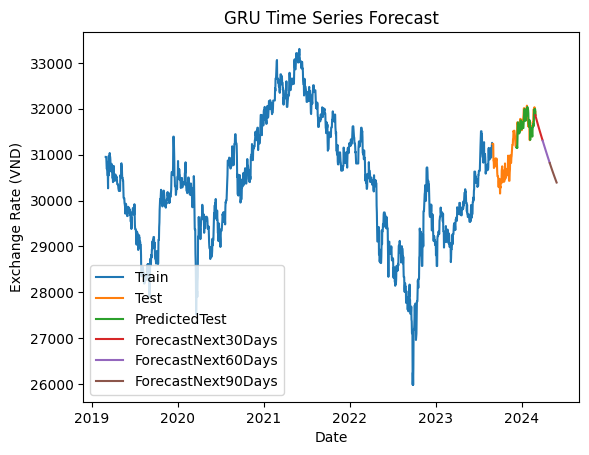

- Model accuracy evaluation: 
RMSE = 158.7110223347517
MAPE = 0.36274554571427553
MAE = 115.03610899390226


In [48]:
implementGRU(train_gbp_3_sc, test_gbp_3_sc)